In [1]:
#import packages to be used during analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import random
import os
from scipy.optimize import curve_fit

# Define Functions

The below code block will define functions we will use during our analysis

In [2]:
def loadFile(path, headers=None):
    '''
    This function will parse a standard HEKA .asc file into a pandas dataframe.

    Arguments: 
    path - a stringIO input of a standard HEKA output .asc file.

    Returns:
    df, dfcache - two copies of the file reformatted into a dataframe.
    '''

    lineIndices = []            
    
    # Splits string at \n and removes trailing spaces  
    with open(path, "r") as f:                        
        rawFile = f.read().strip().split("\n")         

    count=0
    # Finds rows that contain header information to exclude from df                                     
    for line in rawFile:                                  
        if re.search(r"[a-z]+", line) == None:           
            lineIndices.append(count)                     
        count += 1                                    
    
    # Formats headerless file for later df
    processedFile = [rawFile[i].strip().replace(" ", "").split(",") for i in lineIndices]     

    # Use the difference in file size with and without headers to find nSweeps

    if headers == None:
         df = pd.DataFrame(data=processedFile)
    else:
        df = pd.DataFrame(columns=headers, data=processedFile)
    df = df.apply(pd.to_numeric)
    df = df.dropna(axis=0)

    nSweeps = df["index"].tolist().count(0) 

    # Make new column with sweep identity
    df['sweep'] = np.repeat(np.arange(nSweeps) + 1, len(df)/(df["index"].tolist().count(1)))
    return df.reset_index(drop=True)

def preprocess(df):
    df.i *= 1e12
    df.v *= 1000
    df.ti *= 1e3
    df.p /= 0.02
    
    i_blsub = df.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)
    new_df = df.assign(i_blsub = np.array(i_blsub))
    return new_df

def generatePaths(folderPath=os.getcwd(), suffix=".asc"):
    """
    This function will run the preprocess function on all files in a folder.
    """
    path_list = []

    for root, dirs, files in os.walk(folderPath):
        for file in files:
            if file.find(suffix) != -1:
                path_list.append(os.path.join(root, file).replace("\\","/"))
    
    return path_list

def plotSweeps(df, x, y, p_kwargs={}, i_kwargs={}):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))
    f.patch.set_facecolor('white')
    
    for k, g in df.groupby("sweep"):
        ax1.plot(g.ti, g.p, **p_kwargs)
        ax1.set_ylabel("Pressure (mmHg)")
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.axes.xaxis.set_visible(False)
        ax2.plot(g[x], g[y], **i_kwargs)
        ax2.set_xlabel("Time (ms)")
        ax2.set_ylabel("Current (pA)")
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        
    return ax1, ax2

def findSmoothedPeaks(df, smoothing = 5, window=[5100,5400]):
    
    ## Error checking
    if smoothing % 2 == 0:
        raise EvenValueError("You assigned an even value to smoothing. The smoothing value must be an odd integer.")
    elif type(smoothing) == type(1.5):
        raise NonIntegerValueError("You assigned a non-integer value to smoothing. The smoothing value must be an odd integer.")
            
    gdf = df.groupby('sweep')
    datStim = df.query("ti >= @window[0] & ti < @window[1]")
    peaks = datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmax(g.i_blsub)]).reset_index(drop=True)
    npoints = (smoothing-1)/2
    smoothed_peaks = np.zeros(len(peaks))
    smoothed_peaks_sd = np.zeros(len(peaks))
    
    for i in range(len(peaks)):
        ind = peaks.loc[i,'index']
        smoothed_peaks[i] = gdf.get_group(i+1).query("index >= @ind - @npoints & index <= @ind + @npoints").i_blsub.mean()
        smoothed_peaks_sd[i] = gdf.get_group(i+1).query("index >= @ind - @npoints & index <= @ind + @npoints").i_blsub.std()
        
    return pd.DataFrame({"peak_time":peaks.ti ,"mean_peak":smoothed_peaks,"sd_peak":smoothed_peaks_sd})

#Finding mins

def findSmoothedMins(df, smoothing = 5, window=[5100,5400]):
    
    ## Error checking
    if smoothing % 2 == 0:
        raise EvenValueError("You assigned an even value to smoothing. The smoothing value must be an odd integer.")
    elif type(smoothing) == type(1.5):
        raise NonIntegerValueError("You assigned a non-integer value to smoothing. The smoothing value must be an odd integer.")
            
    gdf = df.groupby('sweep')
    datStim = df.query("ti >= @window[0] & ti < @window[1]")
    mins = datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmin(g.i_blsub)]).reset_index(drop=True)
    npoints = (smoothing-1)/2
    smoothed_mins = np.zeros(len(mins))
    smoothed_mins_sd = np.zeros(len(mins))
    
    for i in range(len(mins)):
        ind = mins.loc[i,'index']
        smoothed_mins[i] = gdf.get_group(i+1).query("index >= @ind - @npoints & index <= @ind + @npoints").i_blsub.mean()
        smoothed_mins_sd[i] = gdf.get_group(i+1).query("index >= @ind - @npoints & index <= @ind + @npoints").i_blsub.std()
        
    return pd.DataFrame({"peak_time":mins.ti ,"mean_peak":smoothed_mins,"sd_peak":smoothed_mins_sd})

def findSteadyState(df, window = [5395-20, 5395]):
    
    ## Error checking
    if len(window) != 2:
        raise EvenValueError("Window must be an iterable of length 2 with the start and end points of the region of interest.")
        
    ss_mean = df.query("ti >= @window[0] & ti < @window[1]").groupby("sweep").i_blsub.apply(np.mean)
    ss_sd = df.query("ti >= @window[0] & ti < @window[1]").groupby("sweep").i_blsub.apply(np.std)
    
    return pd.DataFrame({"mean_ss":ss_mean,"sd_ss":ss_sd}).reset_index(drop=True)

def inactivationanalysis(df, dirc="+", smoothing = 5, spwindow = [5100, 5400], sswindow = [5395-20,5395]):
    if dirc == "+":
        sp = findSmoothedPeaks(df, smoothing = smoothing, window = spwindow)
    else:
        sp = findSmoothedMins(df, smoothing = smoothing, window = spwindow)
    ss = findSteadyState(df, window = sswindow)
    return pd.concat([sp, ss], axis=1)

def analyzedtable(filelist):
    for i in range(len(filelist)):
    
        temp = pd.read_csv(filelist[i], header=0, index_col=0)
        filename = filelist[i].split("/")[-1]
    
        if filename.find("PGK") != -1:
            promoter = "PGK"
        elif filename.find("WT") != -1:
            promoter = "WT"
        else:
            promoter = "CMV"

        if filename.find("pos") != -1:
            condition = "pos"
        else:
            condition = "neg"

        temp = temp.assign(promoter = np.repeat(promoter, 5),
                           filename = np.repeat(filename, 5),
                           condition = np.repeat(condition, 5))

        if i == 0:
            agg = temp
        else:
            agg = pd.concat([agg, temp], axis=0)
        
    return agg

def inactivationFits(cell):
    files = generatePaths(suffix = "neg_Preprocessed.csv")
    files = [i for i in files if "._" not in i]
    for f in files:
        if cell.filename[0:-13] in f:
            print(f)
            df = pd.read_csv(f, header=0)
            dfSub = df.query("sweep==1 & ti >= 5000 & ti <= 5500")
            filename = f
            
    peak10percent = cell.mean_peak * 0.1
    dfSubFiltered = dfSub.query("ti >= 5095 & ti <= 5395 & i_blsub <= @peak10percent")

    popt, pcov = curve_fit(doubleExp, dfSubFiltered.ti, dfSubFiltered.i_blsub, p0=[1, 50, 3, 20, 20], maxfev=10000)
    
    ax1, ax2 = plotSweeps(dfSub, "ti", "i_blsub", i_kwargs={"color":"black"})

    xfine = np.linspace(5095, 5400, 1000)
    yfine = doubleExp(xfine, *popt)
    ax2.plot(xfine, yfine, color = "orange", linewidth = 3)
    ax2.set_ylim(1.1 * np.min(dfSub.i_blsub), 10)
    ax2.annotate("tau = " + str(np.round(popt[4], 2)), [5030, -10], size = 16)
    plt.show()

    plt.savefig(filename[0:-17] + "_Inact_Tau.png")
        
    summarydf = pd.DataFrame({"cell":[cell.filename],"y0":[popt[0]], "a1":[popt[1]], "tau1":[popt[2]], "a2":[popt[3]], "tau2":[popt[4]]})
    return summarydf

def doubleExp(x, y0, a1, tau1, a2, tau2):
    return y0 + a1 * np.exp(-(x - 5095)/tau1) - a2 * np.exp(-(x - 5095)/tau2)
    
class Error(Exception):
    """Base class for other exceptions"""
    pass

class EvenValueError(Error):
    """Raised when an even number is passed to an argument that requires an odd input"""
    pass

class NonIntegerValueError(Error):
    """Raised when a non-integer number is passed to an argument that requires an integer input."""
    pass

class ListSizeError(Error):
    """Raised when a non-integer number is passed to an argument that requires an integer input."""
    pass

## Load and Preprocess File

We call the loadFile function to load a file into our workspace for analysis.

Then, our preprocessing will consist of a few steps. First we will convert some of the units into something more convenient:
- i: A -> pA
- v: V -> mV
- ti: s -> ms
- p: v -> mmHg (200 mV / 10 mmHg)

The general notation used for all these conversions are `df.x *= y`. This notation tells python to take the column `x` of the dataframe `df`, multiply each value in it by the constat `y` and set the dataframe column equal to the returned value. 


Next, we will baseline subtract the current and append this baseline subtracted data into a new column called `i_blsub`. Let's talk a bit about the lines of code that accomplish this as they use both numpy and pandas packages.

## Split-Apply-Combine
The split-apply-combine paradigm is one of the most important working principles and is broadly used in any sort of analysis. Oftentimes you want to split your data based on some factor, perform some operation on each group, then return either a summary table or a transformed dataset. Pandas is designed with this workflow in mind and makes it quite convenient notationwise.
In our case what we want to do is as follows:
1. Split the data by sweep number
2. Apply a baseline subtraction based on the mean of the current in a particular time window (500 - 1000 ms)
3. Transform i into a new column i_blsub that is the baseline subtracted current

## Pandas chaining
Most often, when we apply functions to an object and we nest those functions like f(g(x)) we work from the inside out. So we apply g(x) first then apply f(x) to the output of g(x). For example the function `print(mean(x))` will find the mean of x then print that value.

Pandas allows for a different workflow called "chaining" or "piping". You'll find similar ideas in R when using the `dplyr` package. You can recognize this by the "." (dot) syntax. Anytime you see a variable or operation followed by a period that means the next command will be applied to the output of what is to the immediate left of that period. A simple example is `df.i` which is simply get column `i` of the dataframe `df`.

## Lambda Functions

Lambda functions are essentially quick one-off functions you may write. Typically, when you write functions you want to reuse you use the more typical convention of:

```
def myFunction(args):
    var = dosomething(args)
    return var
```

However, at times you just want something quick and for a single use. The general form of a lambda function is ax follows:

```
lambda x: dosomething(x)
```

The lambda function will return whatever the output of the operations performed on x is. Here, x is an anonymous variable so we can really call it anything.

Now we have all the tools (pandas chaining to accomplish split-apply-combine and lambda functions) to breakdown the following line of code:

`i_blsub = df.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)`

At first glance it may seem complicated but let's go step-by-step. 

1. We split the data into groups based on sweep number with df.groupby("sweep"). Groupby can either take as arguments a single column name as a string or multiple column names as a list of strings. For instance, you can say `df.groupby(["sweep", "cellID"])` if we had a separate column of cellIDs and it will use both columns to form unique groups. In python `[]` denotes lists. 

2. We want to do something to each group. That is where the `apply` operation comes into play. The apply function takes a single argument, another function, that is to be applied to each group that is passed to it in the chaining operation. For instance, one way to find group means is to type `df.groupby("sweep").apply(mean)` and it will find the mean of every group. 

3. However, we don't just want the group means. We want only the mean current within a certain region of the trace. Even better, we want to subtract this mean current from the raw current within each group. To do this we use a lambda function. Here, our lambda function is defined as `lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i`. Notice the use of pandas chaining within the lambda function. As a result we can read what it is doing from left to right. We know based on the chaining we did earlier that whatever `apply` does will be applied groupwise so we call our variable `g` for group (for clarity). We want to subtract something from the current columnn in each group so we call that column using `g.i`. Now we need to deal with windowing and finding the mean. We know that each group `g` is essentially a mini dataframe so we can `query` that dataframe to window a particular part of it. Again, using chaining we can do this by typing `g.query()`. We can then tell it how to query our dataframe. We want the region where the time is between 500 and 1000 ms. This can be accomplished by writing `'ti < 1000 & ti > 500'`. I much prefer query to classical subsetting because it is optimized by the wonderful people that wrote pandas to be performant and it is very easy to read and figure out what is going on. Python is all about readability. `g.query("ti < 1000 & ti > 500")` gives us the subset of the dataframe we are interested. Now we can find the mean of each column of the dataframe by chaining on the `mean` operation giving us `g.query("ti < 1000 & ti > 500")`. At this stage we have the means of all the columns within this subset of the dataframe but we only care about the mean of the current so we can access this by chaining on a call to the column as follows: `g.query("ti < 1000 & ti > 500").mean().i`. Great! Now our lambda function can output the raw current trace `g.i` minus the mean within this particular region we found with `g.query("ti < 1000 & ti > 500").mean().i`.

We save all of this to our new variable i_blsub but it would really be much more useful to add this as a new column to our original dataframe. This is relatively easy since we know that the column should be the same size (since we are simply transforming the column `df.i`. We handle this in the next line of code.

`df = df.assign(i_blsub = np.array(i_blsub))`

We transform the contents of our variable i_blsub into a numpy array with the function `np.array()`. This just avoids some errors that would come up based on the grouping of `i_blsub`. It will get rid of any grouping and just make it an array of numbers. Then we can update our dataframe `df` by setting it equal to the output of `df.assign()`. `df.assign()` works as follows:

`df.assign(column_name = column_contents)`

So, we will add a new column `i_blsub` and assign it the contents of the variable `i_blsub` after transforming it into a numpy array.

`df = df.assign(i_blsub = np.array(i_blsub))`.


In [ ]:
files = generatePaths()
dat  = loadFile(files[0], headers= ["index", "ti", "i", "tp","p","tv","v"])

dat.i *= 1e12
dat.v *= 1000
dat.ti *= 1e3
dat.p /= 0.02

## Baseline subtract
i_blsub = dat.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)
dat = dat.assign(i_blsub = i_blsub.reset_index(drop=True))


# Defining reusable functions

We talked about functions a bit earlier when I mentioned lambda functions. Whenever you have an operation you know you will perform repeatedly it is a good idea to package the contents into a function. We developed a workflow for preprocessing our data for later analysis so now lets put this all into a function! Whenever you define a function in python the organization is as follows.

``` 
def myfunction(args):
    output = dosomething(args)
    return output
```

It starts with `def` for define. This is followed by whatever you want to call your function (it should make sense). In the example case this is just called myfunction. Then we list any arguments which is a list of things we want to pass to the function. The simplest function may only have a single argument. Some functions have many. These arguments are passed to the function's scope. We need to end this initial definition with a colon (python convention) and any subsequent lines that are a part of the function should be indented. Then, we put any operations we want performed in the body of our function. Finally, we want to return the output of those operations back to the global scope. I used the word scope here a few times so let's talk about it.

## Scope 

Scope is simply the space of variables that your function can see and access. All the variables we have defined so far have been in global scope. However, you can define variables within a function that can only be seen within the function unless explicitly returned to global scope. For instance, if we just type in python `apple = 4` then later call the variable `apple` it will return the value `4`. That's because we defined the variable in global scope. 

A variable can be defined within a function for temporary use within the scope of what that function needs to do. Let's take the example function:

```
def myfunction(x):
    y = 3x
    z = 4y + 2
    return z
```

We can then have the function operate on some number and save it to a new variable as follows: `orange = myfunction(2)`. Now, we can call `orange` and get the output of the function which in this case is `26`. However, if we type `y` or `z` we get an error. This is because these variables are not in the global scope. They were only temporarily used by the function to generate the output.

## Putting it all together

Okay, we now have the tools to build our function. Let's call it preprocess. I typically like to name the arguments something informative. For instance df tells us that the argument is a dataframe. The function will convert units and perform background subtraction on an input dataframe then return a new, updated dataframe. The body can simply be the code we wrote earlier. Importantly, since our argument is called df, regardless of what the dataframe may be called in global space, within the function it is called df. So we will have to change the name in the function body accordingly.

```
def preprocess(df):
    df.i *= 1e12
    df.v *= 1000
    df.ti *= 1e3
    df.p /= 0.02
    
    i_blsub = df.groupby("sweep").apply(lambda g: g.i - g.query("ti < 1000 & ti > 500").mean().i)
    new_df = df.assign(i_blsub = np.array(i_blsub))
    return new_df
```
dat  = loadFile("20220128_N2A_pkg_cmv_mp1.asc", headers= ["index", "ti", "i", "tp","p","tv","v"])


Now, lets see our new function in action

In [ ]:
files

In [ ]:
files = generatePaths()
dat  = loadFile(files[0], headers= ["index", "ti", "i", "tp","p","tv","v"])
datPreprocessed = preprocess(dat)
datPreprocessed

We just accomplished in 2 lines of code what previously took 6. Functions are a great way to modularize your code. As you come up with complicated routines, if certain parts of that routine fit into neat modules you should move them into functions. It has the added benefit of making troubleshooting easier. If something goes wrong with a line of code during analysis it is much easier if you can direct your attention to fixing a single small function rather than a huge mess of scripts that aren't organized.

As a note, see that we simply typed `preprocess(dat)` instead of `preprocess(df=dat)`. Python is smart enough to know that we want to assign dat to df since the function only has a single argument so this is shorthand. Even if there were multiple arguments python will try to automatically place them in the order that they are defined by the function. In most cases where there are multiple arguments you likely want to call the variables explicitly however for readability.


# Visualize Data

I will not go over plotting until later so for now simply run the following code without worrying about what its doing. We will initially visualize all the data and highlight the region used for background subtraction. Check that there isn't a lot of noise here that may affect the background subtraction process. The relevant region (between 500 and 1000 ms) is highlighted in red. You should check every step of your analysis to make sure that what you're seeing makes sense. Automation is great but you need to check for errors in your analysis pipeline regularly. ESPECIALLY if you change a protocol.

The below code will plot the stimulus over the response and cleans up the graphs a little bit. Currently, the plots for every sweep is overlayed. Matplotlib is powerful, flexible, and ugly to code. Why don't you take what you learned to this point and create a plotting function called `plot_sweeps` using the code below?

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datPreprocessed.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.axvspan(500, 1000, alpha=0.03, color='red')
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

In [ ]:
roi=[4900, 5600]
datSub = datPreprocessed.query("ti > @roi[0]  & ti < @roi[1]")

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

# Finding Peaks

Next, we want to start developing the actual analysis. For this we will build a few functions to help us. The first function we will build will be to find peaks. We discussed a few conditions that are import to finding the proper peaks. First, we need a means to find the maxima of the current trace. Second, we need a means to tell it to look for this maxima within a specific window of time to avoid, for instance, picking up the capacitive transients during the voltage change. When you are trying to think of how to code a particular analysis you should modularize how you would do it into discrete steps much like we are doing here. A good practice is to dedicate 1 line of code to a single sentence. So say what you want to do in a sentence then simply translate each sentence into a line of python code!

In sentences:
"I need to filter the trace to only look within the window of time that the stimulus is present. Then, I want to group the data by sweep and find the time of the maximum current."

So let's deal with filtering first. We can again turn to the pandas query. From the above graph we can see that our stimulus interval is between 5100 and 5400 ms. It is reasonable to expect our peak should be within the stimulus interval. So we can write our query as follows:

```
datStim = dfPreprocessed.query("ti >= 5100 & ti < 5400")
```

Now we have a new dataframe `dfStim` that only has data within the stimululs region. We can now move on to the second sentence. "I want to group the data by sweep and find the time of maximum current". Well, this looks like the perfect use of split-apply-combine so lets turn to pandas chaining here. Instead of the mean this time we are interested in the max. Python has a built-in function `max()` which we can call with apply here. Since, we only care about the max current we can precede the apply function with a `.i` to only operate on the one column.
```
datStim.groupby("sweep").i.apply(max)
```

It may however be more useful to have more information and get the whole row associated with the peak. Here, I will again use a lambda function and use the numpy function `argmax()`. This function is specifically designed to find the index of the maxima. Then, I can use this to index my dataframe using `.iloc` and extract the whole row. I also chain on the command recet_index(drop=True) for formatting reasons. Otherwise pandas will add an indexing column called `sweep` based on the groupby element. The code is as follows:


```
datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmax(g.i)]).reset_index(drop=True)
```
## Indexing Dataframes

Similar to indexing lists and arrays you can use numbers to index dataframes. The convention is slightly different. For dataframes you should precede your square brackets with `.iloc` which is short for item location or index location.

In [ ]:
datStim = datPreprocessed.query("ti >= 5100 & ti < 5400")
peaks = datStim.groupby("sweep").apply(lambda g: g.iloc[np.argmax(g.i)]).reset_index(drop=True)
peaks

## Visualize peaks 

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
for k, g in peaks.groupby("sweep"):
    ax2.scatter(g.ti, g.i_blsub, facecolors='none', edgecolors='b', s=200, alpha=k*0.2)
    

# Finding Steady State Current

We are next interested in an estimate of the steady state currents. Let's take the same approach and break our problem down into sentences to approach this question. Your sentences may be something like the following:

"I need to filter the trace to only look at the last 20 ms. I then need to group the data by sweep and find the average current in this region as an estimate of steady state current."

This is again a pretty simply 2 step process. For filtering we will again use `pd.query()`. Our stimulus actually ends closer to 5395 ms rather than 5400 so we will take this to be the end of our filter. The beginning will simply be 5395-20. We can perform this operation with the following code.

```
datPreprocessed.query("ti >= 5395-20 & ti < 5395")
```

We don't need to save this to its own variable. Instead we will chain the second part of this code onto what we just did. The second sentence says I need to group the data by sweep, and find the mean current. In code this will look like the following:

```
ss = datPreprocessed.query("ti >= 5395-20 & ti < 5395").groupby("sweep").i.apply(np.mean)
```

Notice if you read from left to right the flow should make logical sense. First, we `.query` the data to filter the region of interest, then we `.groupby` the data to group by sweep, next we isolate the current column with `.i` since that is what we are interested in, and finally we `.apply` the `np.mean` function to find the average. The output is saved to the variable ss.

```
```


In [ ]:
ss_mean = datPreprocessed.query("ti >= 5395-20 & ti < 5395").groupby("sweep").i.apply(np.mean)
ss_sd = datPreprocessed.query("ti >= 5395-20 & ti < 5395").groupby("sweep").i.apply(np.std)

## Visualize Peaks and SS on the same graph

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
for k, g in peaks.groupby("sweep"):
    ax2.scatter(g.ti, g.i_blsub, facecolors='none', edgecolors='b', s=200, alpha=k*0.2)

for i, val in enumerate(ss):
    ax2.plot([5395-20, 5395], [val, val], color = 'red', alpha=(i+1)*0.2, linewidth=4)

Check to make sure that your annotations are where you would expect them to be based on the raw data. If not we'll need to try and figure out what is going on.

# Smoothing Peaks

Right now we are just taking the raw maximum but this may not be the best idea as noise transients can heavily influence this value. We can reduce this by taking the average of n points around our peak. Let's start with something like n=5. In this case we will take the average of the peak along with 2 points before and 2 points after. Fortunately, instead of simply saving the peak value we saved the whole row corresponding to the peak current in the variable `peaks`.

In [ ]:
peaks

You can see that we have a column called `index`. With this, we know what index (or row number) corresponds to the peak current for each group. We can then just take the two rows above it, two rows below it, and average the values to get an estimate of the peak that is more robust to noisy variations. We will accomplish this using a for loop.


## For loops

There are broadly 2 types of loops in python a `while` loop where you repeat some operation while a condition holds true. In practice, you rarely use these as you run the risk of that condition never being true if you aren't careful and getting stuck in an infinite loop that can lock up your computer. Instead most operations can be accomplished with a `for` loop. Unlike `while` loops for loops have a defined endpoint. For instance, you may write something like the following:

Notice that the output it prints numbers from 0 to 4. `range()` is a convenience function that will make a list from 0 to n-1 where n, in this case, is 5. So what the for loop does is print out the value of i which will iterate over all values in the list. In essence, it is just repeating the operations in the body of the for loop 5 times. Also notice that as per python convention the line defining the `for` loop is followed by a colon and everything that is a part of the for loop after that is indented. This is the same as for defining functions and is python's way of keeping code organized and readable.

We can use a similar principle on our data. We know that we have 5 grouups (5 sweeps) and we also know that we have 5 rows in our peaks dataframe. What we need is some what to match them up. Let's put this into works as usual.

"For every group I need to match it with the corresponding row in my variable peaks. Then I need to get the 2 rows above it and the 2 rows below it from the group. I'll average the current across the 5 rows to get my smoothed peak."

Alright! We broke our problem down into parts. Now let's tackle each one.

1. "For every group I need to match it with the corresponding row in my variable peaks."

First, lets save our grouped dataframe into a variable `gdf`. This is accomplised with the line `gdf = datPreprocessed.groupby('sweep')`. Next, our `for` loop will come into play. We saw that we can use `range()` to get it to repeat a fixed number of times. Remember that lists are indexed in python from 0 to n-1 exactly the same way that the `range()` function counts. Unfortunately, pandas uses a slightly different convention and will count its group numbers starting at 1. This is easy to get around though. We will start with the same loop from earlier but instead of hard coding the number 5 lets make it more flexible. Down the road we may want to average peaks across a different number of traces and we don't want our code to break. Instead of saying `range(5)`. We will let the length (number of rows) of the dataframe dictate how long the loop will be using the `len()` function. Our loop will start off looking something like as follows:

```
for i in range(len(peaks))
    dosomething
```

This way, if our peaks dataframe had 10 rows it will run 10 times for instance. In this case, `i` is acting as our counter. So we know the first time it runs `i` is equal to 0. We also know that the first row (index 0) of peaks corresponds to the first group (index 1) of the grouped dataframe. So we can index into our dataframe by typing `peak.loc[i, 'index']` and saving the value in that location to the variable `ind`. 

## Indexing in Pandas
Pandas indexing uses `.loc` or `.iloc`. If you are using column names you need to use `loc` if you are just using integer numbers you can use `iloc`.

Notice here instead of using a number to index I am using the counter `i` so that the first time it goes through the loop it's pulling from row 0, the second time it pulls from row 1, etc. You can notice how powerful this can be rather than having to type the number of the row each time. It's already useful with 5 rows. Imagine if we had something like 10000 rows. 

## pd.get_group() to get individual groups from a grouped dataframe

Similarly, we need to call the appropriate group from the grouped dataframe. For this we use the pandas command `.get_group()`. Since pandas numbers starting at 1 we cannot simply pass the counter variable `i`. As I mentioned earlier we can easily fix this. All we have to do is add 1 to the variable. So, instead of `.get_group(i)` we type `.get_group(i+1)`.

Now our loop would look something like this:

```
for i in range(len(peaks)):
    ind = peaks.loc[i,'index']
    gdf.get_group(i+1)
```

2. "Then I need to get the 2 rows above it and the 2 rows below it from the group."

This sounds like a problem for `pd.query()` again since it is a matter of filtering. We have the relevant index saved in the variable ind so we can chain this onto our current loop as follow:

```
for i in range(len(peaks)):
    ind = peaks.loc[i,'index']
    gdf.get_group(i+1).query("index >= @ind - 2 & index <= @ind + 2")
```
We take advantage of the fact that index is just a row counter so we can add subtract 2 and add 2 to get the relevant range.

3. "I'll average the current across the 5 rows and find the standard deviation to get my smoothed peak."

Finally, we isolate the current column and find the mean as follows just like we have before.

```
for i in range(len(peaks)):
    ind = peaks.loc[i,'index']
    gdf.get_group(i+1).query("index >= @ind - 2 & index <= @ind + 2").i.mean()
```

This is doing what we want it do but we currently aren't saving the results anywhere. Here, we can again take advantage of our counter. We can initialized an empty array of zeros and call it `smoothed_peaks`. Then each time we run the loop we will assign the appropriate index in that array with the value of the mean for that iteration of the `for` loop. The final code can be seen below.

In [ ]:
gdf = datPreprocessed.groupby('sweep')

smoothed_peaks = np.zeros(len(peaks))

smoothed_peaks

# Visualize Smoothed Peaks

I'll plot the smoothed peaks as horizontal magenta lines over the other annotations and you can see how they line up.

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1,3]}, figsize=(20,10))
f.patch.set_facecolor('white')

for k, g in datSub.groupby("sweep"):
    ax1.plot(g.ti, g.p, color="maroon")
    ax1.set_ylabel("Pressure (mmHg)")
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)
    ax2.plot(g.ti, g.i_blsub, linewidth=0.5, color="black", alpha=k*0.2)
    ax2.set_xlabel("Time (ms)")
    ax2.set_ylabel("Current (pA)")
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
for k, g in peaks.groupby("sweep"):
    ax2.scatter(g.ti, g.i_blsub, facecolors='none', edgecolors='b', s=200, alpha=k*0.2)

for i, val in enumerate(ss):
    ax2.plot([5395-20, 5395], [val, val], color = 'red', alpha=(i+1)*0.2, linewidth=4)

for i, val in enumerate(smoothed_peaks):
    ax2.hlines(val, xmin=5050, xmax=5395, color = 'magenta', alpha=(i+1)*0.2, linewidth=1)

# Full Analysis

Let's summarize what we have developed thus far. We have the code we need to preprocess our data by converting units and baseline subtracting, to visualize our data by plotting, to find and smooth peak estimates, and to find the mean steady-state current over a set time window. This initial development phase is often followed by a phase of restructuring our code into discrete functions. We may also want to refine some areas for improved performance and readability. This process of essentially "cleaning up" your workflow and modularizing it falls under the umbrella of **refactoring**. If we look at the definition of refactoring on wikipedia we see the following:

> In computer programming and software design, code refactoring is the process of restructuring existing computer code—changing the factoring—without changing its external behavior. Refactoring is intended to improve the design, structure, and/or implementation of the software (its non-functional attributes), while preserving its functionality. Potential advantages of refactoring may include improved code readability and reduced complexity; these can improve the source code's maintainability and create a simpler, cleaner, or more expressive internal architecture or object model to improve extensibility. Another potential goal for refactoring is improved performance; software engineers face an ongoing challenge to write programs that perform faster or use less memory.

At this time you should also document your code so that if you ever need to return to it you can quickly understand what it is doing and how it is doing it. While it is an easy step to skip over for the sake of reproducibility it is critical that you do not. The strength of python is its readability when compared to many other languages. 

In [3]:
files = generatePaths(suffix = ".asc")
files;

In [97]:
files = generatePaths(suffix = ".asc")

##For weirdos

#fileList = np.unique(poscells.query('test < 0').filename)

#filePaths = []

#for i in range(len(files)):
    #if files[i].split('/')[-1][0:-4]+"_analyzed.csv" in fileList:
       # print(files[i])
        #filePaths.append(files[i])
    #else:
     # continue

for file in files:
    postraces = loadFile(file, headers= ["index", "ti", "i", "tp","p","tv","v"])
    filename = file.split("/")[-1][0:-4]
    
    print(filename)
    pospreprocessed = preprocess(postraces)
    pospreprocessed.to_csv(file[0:-4] + '_Preprocessed.csv')
    
if filename[-3:-1] == "po":
        dirc = "+"
    else:
        dirc = "-"

    posanalyzed = inactivationanalysis(pospreprocessed, dirc=dirc, spwindow = [5100, 5395])
    posanalyzed.to_csv(file[0:-4] + "_analyzed.csv")
    
    ax1, ax2 = plotSweeps(postraces, "ti", "i", p_kwargs={"color":"maroon","linewidth":0.5}, i_kwargs={"color":"black","linewidth":0.5})
    plt.savefig(file[0:-4] + '_rawTraces.png', bbox_inches='tight', dpi=300, transparent=False)
   
    ax1, ax2 = plotSweeps(pospreprocessed, "ti", "i_blsub", p_kwargs={"color":"maroon","linewidth":0.5}, i_kwargs={"color":"black","linewidth":0.5})
    ax1.set_xlim([4900,5600])
    ax2.set_xlim([4900,5600])
   
    for i in range(len(posanalyzed)):
        ax2.scatter(posanalyzed.peak_time, posanalyzed.mean_peak, facecolors='none', edgecolors='b', s=200)
        ax2.plot([5395-20, 5395], [posanalyzed.mean_ss, posanalyzed.mean_ss], color = 'red', linewidth=1)
   
    plt.savefig(file[0:-4] + '_analyzedTraces.png', bbox_inches='tight', dpi=300, transparent=False)
    plt.close('all')

20220210_N2A_WT10_pos
20220210_N2A_WT11_pos
20220210_N2A_WT5_pos
20220210_N2A_WT2_pos
20220210_N2A_WT3_pos
20220210_N2A_WT4_pos
20220210_N2A_WT1_pos
20220210_N2A_WT6_pos
20220210_N2A_WT7_pos
20220128_N2A_mp1_PGK3_pos
20220128_N2A_mp1_PGK2_pos
20220128_N2A_mp1_PGK1_pos
20220126_N2A_mp1_PGK2_pos
20220126_N2A_mp1_CMV1_pos
20220126_N2A_mp1_PGK1_pos
20220126_N2A_mp1_CMV3_pos
20220126_N2A_mp1_CMV2_pos
20220127_N2A_mp1_PGK3_pos
20220127_N2A_mp1_PGK2_pos
20220127_N2A_mp1_CMV1_pos
20220127_N2A_mp1_PGK1_pos
20220127_N2A_mp1_CMV4_pos
20220127_N2A_mp1_CMV3_pos
20220127_N2A_mp1_CMV2_pos
20220202_N2A_mp1_CMV1_pos
20220202_N2A_mp1_PGK1_pos
20220202_N2A_mp1_CMV4_pos
20220202_N2A_mp1_CMV3_pos
20220202_N2A_mp1_CMV2_pos
20220203_N2A_WT5_pos
20220203_N2A_WT2_pos
20220203_N2A_WT3_pos
20220203_N2A_WT4_pos
20220203_N2A_WT1_pos
20220204_N2A_WT3_pos
20220204_N2A_WT1_pos
20220125_N2A_mp1_PGK2_pos
20220125_N2A_mp1_CMV1_pos
20220125_N2A_mp1_PGK1_pos
20220125_N2A_mp1_CMV2_pos
20220201_N2A_mp1_PGK3_pos
20220201_N2A

# Data Visualization

## Loading and Triaging Data

First, we will start by loading in our data and taking the subset that passed our triaging criteria. Make note of how you triage and take care not to be overly selective as this may bias your results. Some things we looked out for were stark delays in the pressure response and considerable noise in the recording. We previously added a column to our data, `usable`, where a 1 indicates passing our triaging criteria and a 0 indicates failing. We can then use pandas querying to simply take the subset of the data where the value in the column `usable == 1`. Remember, a logical test for equality in most programming languages uses double = signs since single = signs are often reserved for variable assignment.

In [4]:
tablesummary = pd.read_csv("inactivation_summary.csv", header = 0)
usabletablesummary = tablesummary.query("usable == 1")

## Plotting Packages

We will be using matplotlib.pyplot as our plotting library. This library was developed in python to have functionality very similar to plotting in Matlab (hence the name). The advantage of matplotlib is that it is incredibly flexible. You can make almost any custom plot you can think of. However, the caveat is that the code can often be somewhat ugly and hacky to get it to do what you want. There are MANY plotting libraries out there. Some examples with short descriptions are listed below:

* **Seaborn**: This is a statistical plotting library that acts as an extension of matplotlib. The language for plotting and summarizing data is quite a bit cleaner but what you gain in user-friendliness you give up in flexibility.

* **ggplot2**: ggplot2 uses the grammar of graphics paradigm where a plot is built up in layers. It is extremely powerful and super flexible. The package originated in R and I often go back to R to use it. I personally think ggplot2 is among the most powerful, flexible, and intuitive plotting libraries out there. There are other packages that have adopted the grammar of graphics paradigm due to the success of ggplot2 but I would highly recommend this one. There is a version of ggplot for python but I am not sure it is quite as well developed as the one in R.

* **Altair** Altair is a plotting library that had some popularity a few years ago when I used python more. It adopted the grammar of graphics paradigm that ggplot uses and so may be a good choice on python and worth checking out.

* **Plots** Plots is the basic plotting library on Julia. It is also fairly easy to use and allows for layering of different kinds of plots on top of one another (for instance a scatterplot on a barplot). Similar to matplotlib you can achieve almost anything with variable levels of hacky solutions. It is far more readable and offers multiple backends some of which allowing for some interactivity. A pain point for many Julia users however is the time to first plot. The first plot tends to take a long time to load. This is due to the way the Julia language works with Just-in-time compiling but subsequent plots will be faster.

* **Makie** Makie is a GPU (graphics processor unit) powered plotting library in Julia. This means it is incredibly fast even when handling large datasets. It is built on the Algebra of Graphics paradigm which, as far as I can tell, is quite similar to grammar of graphics. This is also an incredibly flexible language allowing for the generation of gorgeous plots (you can see https://lazarusa.github.io/BeautifulMakie/ for examples). 

As you can see there is no shortage of options especially if you are willing to branch out into other languages. Don't be afraid to do so. After learning your first language it becomes much easier to learn your second. The basic logic is usually quite similar so it's just a matter of learning the syntax. I will switch languages all the time. For instance I take advantage of the power of R in statistics, Python for its mature packages, and Julia for speed to put together my own analysis. 

## Figure and Axis in Matplotlib.pyplot

If you look at the very top of this document where you load in your modules you can see `import matplotlib.pyplot as plt`. That is, we import the plotting package matplotlib.pyplot and make it such that we call any function within it by preceding the function with the prefix `plt` as shorthand. This is much more convenient than having to type `matplotlib.pyplot.figure()` every time we wanted to make a figure.

Each time I initialize a plot I will initialize two things: a figure and an axis. I will always save the figure to the variable `f` going forward and axis will be saved to the variable `ax` if there is only 1 or `ax1, ax2, ax3, ...` if there are multiple for example. 

The figure is simply an object that holds the information for the entire panel which may contain multiple subplots or axis. For simplicity, we will use only a single plot each time going forward but you can see the documentation for how to organize subplots into panels if you so choose. 

The axis, perhaps counterintuitively, refers to the plot itself and any associated styling as opposed to how your used to thinking about it as referring to the abscessa or ordinate of a graph. This is generally the way the term axis is used in other plotting libraries as well. Any customizations to a plot such as adding data, axis labels, tick labels, axis limits, titles, etc. will be done to the axis element.

I can initialize a single figure and axis using the command:

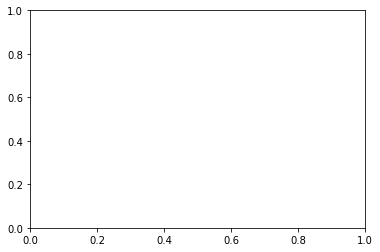

In [5]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

`plt.subplots()` will create both a figure and axis object so we save them to the variables `f` and `ax` respectively. You can see that initially our figure is blank. The default axis styling is to have a box around the plot but we can customize this later. The first line of code is really sufficient to initialize the figure and axis, however by default the background is transparent. If we were to save this figure you would see that this is the case. I typically like to set a white background and so the second line, `f.patch.set_facecolor('white')` sets a white background on the entire figure.

## Plotting a histogram

We now have a blank axis in a figure with a white background. Let's add some data to it. Recall that our data is currently saved in the variable `ax`. We can plot data in multiple ways on an axis by calling the appropriate plotting command. For a histogram this would be `.hist()`. First, Let's do some pandas querying to isolate our positive and negative voltage traces respectively (Make sure you know what voltages you used and not just that one is positive and the other negative). 

In [6]:
#poscells = usabletablesummary.query("condition == 'pos'").reset_index(drop=True)
negcells = usabletablesummary.query("condition != 'pos'").reset_index(drop=True)

NameError: name 'usabletablesummary' is not defined

Next, we need to group our data by individual cell and get the ratio of the mean peak from the last sweep relative to the first. The grouping can be accomplished with pandas groupby method and we will use the `filename` column since each cell has a unique filename. We can isolate the mean_peaks column by following the `.groupby` with `.mean_peaks`. Finally, pandas has convenience functions for getting the first and last element which are `.first()` and `.last()` respectively. The full code chained together is as follows:

In [7]:
posratios = poscells.groupby(["filename"]).mean_peak.last() / poscells.groupby(["filename"]).mean_peak.first()
negratios = negcells.groupby(["filename"]).mean_peak.last() / negcells.groupby(["filename"]).mean_peak.first()

Finally, we are ready to plot the data. Let us start with the positive data. We already intialized our axis a few steps earlier so we will call `.hist` on `ax` and tell it what data to make into a histogram.

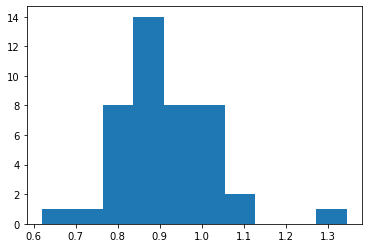

In [8]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posratios);

## Styling our histogram

This is sufficient to make a histogram of our data but now lets style it a bit to make it look more appealing and interpretable. Each plotting function has different arguments. It is always best to check the documentation (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) if you are unsure of how to make any changes you are interested in. One such argument for histograms is setting the number of bins. Matplotlib has a default algorithm for determining optimal bin size but we may want to customize this. Typically, the arguments are intuitive. For instance, to change the number of bins we simply set `bins = n` where n is an integer number.

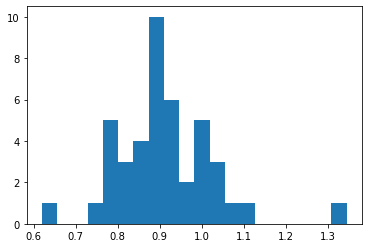

In [9]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posratios, bins=20);

We can also change things like color. Color should in general be used sparingly and only where necessary for visual clarity. We will simply make the bars black.

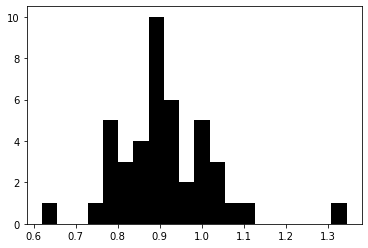

In [10]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posratios, bins=20, color="black");

At this point the data look pretty presentable but we need axis labels to tell us what the data is supposed to represent. Further, I tend not to like the box around the plot so we will remove that as well. This can be done in a few lines. Notice that each style we apply is preceded by `ax` and unlike the style we applied to the data which was in the call to the plotting function itself (`ax.hist()`) these are applied separately.

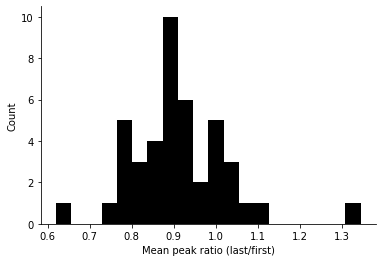

In [11]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posratios, bins=20, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Mean peak ratio (last/first)');

## Saving a plot

Finally, we need to save our plot so that we can include it in our awesome lab meetings. For this we call `plt.savefig()` which will save the most recent figure. Altogether the code will look as follows from start to finish.

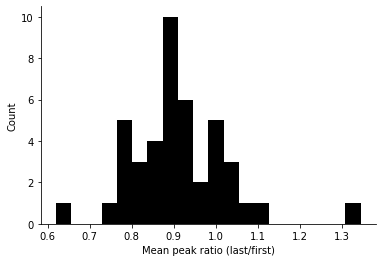

In [12]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posratios, bins=20, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Mean peak ratio (last/first)');
#plt.savefig("PositivePeakRatioHistogram.png")

Let's quickly make the same histograms for our negative peaks.

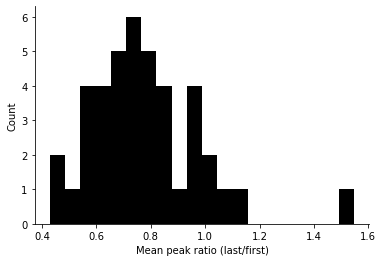

In [13]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(negratios, bins=20, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Mean peak ratio (last/first)');
#plt.savefig("NegativePeakRatioHistogram.png")

## Conclusions and next steps

Use what you learned here to generate the same histograms for your steady-state currents. With the data in hand let us go back to our initial question. Is it appropriate to average our data for peaks? Think about how this data may change the way we analyze the rest of the data going forward.

## Plotting mean peak currents by construct

Based on the histogram you may have come to the conclusion that at least for positive voltages averaging may be fine. Next, you likely want to ask the question: "Is there a difference in the maximum current amplitude between the three conditions: CMV promoter, PGK promoter, and native expression?". For this, you recommended a barplot representation. Barplots are great, simple plots for comparison but the hide a lot of important information so I will almost always recommend overlaying the raw data. There may be interesting patterns in the distribution or clear outliers that are hidden if you simply plot the bars. In the next section we will tackle creating this plot.

First, we will generate the data for our bars and for our individual data points. For our individual points we expect each cell to contribute 1 point which is determined by the mean peak current of the 5 sweeps during our experiment. So, we will need to use pandas again here to groupby the cell and find the mean peak current for each cell.

In [14]:
poscells

,sweep,peak_time,mean_peak,sd_peak,mean_ss,sd_ss,promoter,filename,condition,pipette_resist,seal resist,notes on raw data,notes on analyzed graph,usable
0,0,5383.2,54.260656,0.828253,53.841137,0.609465,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
1,1,5382.9,53.093271,0.843926,52.769558,0.567646,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
2,2,5113.3,52.326861,0.797504,51.630051,0.598199,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
3,3,5315.0,53.646424,0.709310,52.089856,0.681380,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
4,4,5137.9,56.216107,0.845135,53.465476,1.035798,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0,5362.2,57.870818,0.698276,56.626593,0.657057,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1
211,1,5286.9,55.153876,1.078700,53.901550,0.808959,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1
212,2,5359.3,53.579950,0.945787,52.296000,0.700882,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1
213,3,5378.2,53.746585,0.889893,52.849285,0.704752,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1


## Subtract voltage-dependent current from all positive traces

Implementing a fix here for the issue of voltage-dependent current contributions I mentioned to you. It is not built for speed since it goes through and essentially re-preprocesses the relevant files, finds the voltage-dep current over the window 5050 and 5095 then subtracts it from your mean_peak column in the poscells dataframe but it gets the job done.

In [14]:
poscells

,sweep,peak_time,mean_peak,sd_peak,mean_ss,sd_ss,promoter,filename,condition,pipette resist,seal resist,notes on raw data,notes on analyzed graph,usable
0,0,5383.2,54.260656,0.828253,53.841137,0.609465,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
1,1,5382.9,53.093271,0.843926,52.769558,0.567646,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
2,2,5113.3,52.326861,0.797504,51.630051,0.598199,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
3,3,5315.0,53.646424,0.709310,52.089856,0.681380,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
4,4,5137.9,56.216107,0.845135,53.465476,1.035798,WT,20220210_N2A_WT10_pos_analyzed.csv,pos,3.87,1.97,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0,5362.2,57.870818,0.698276,56.626593,0.657057,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1
210,1,5286.9,55.153876,1.078700,53.901550,0.808959,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1
211,2,5359.3,53.579950,0.945787,52.296000,0.700882,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1
212,3,5378.2,53.746585,0.889893,52.849285,0.704752,WT,20220209_N2A_WT4_pos_analyzed.csv,pos,5.23,1.37,NaN,peaks at end of stim,1


In [15]:
files = generatePaths(suffix = ".asc")
cells =  np.unique(poscells.filename)

vcurrents = pd.DataFrame(columns = ['filename', 'mean_vcurrent'])
count = 0
for i in cells:
    count += 1
    for j in files:
        if i[0:-13] in j:
            print(str(count) + "/" + str(len(cells)))
            tempdat  = loadFile(j, headers= ["index", "ti", "i", "tp","p","tv","v"])
            tempdatPreprocessed = preprocess(tempdat)
            tempvcurrents = tempdatPreprocessed.query('ti > 5050 & ti < 5070').groupby('sweep').i_blsub.mean().reset_index(drop=True)
            for k in tempvcurrents:
                vcurrents = vcurrents.append({
                    'filename':i ,
                    'mean_vcurrent':k}, ignore_index=True)
        else:
            continue

poscells = pd.merge(poscells, vcurrents, on="filename")

1/43
2/43
3/43
4/43
5/43
6/43
7/43
8/43
9/43
10/43
11/43
12/43
13/43
14/43
15/43
16/43
17/43
18/43
19/43
20/43
21/43
22/43
23/43
24/43
25/43
26/43
27/43
28/43
29/43
30/43
31/43
32/43
33/43
34/43
35/43
36/43
37/43
38/43
39/43
40/43
41/43
42/43
43/43


In [16]:
poscells.loc[:,'mean_peak'] = poscells.mean_peak - poscells.mean_vcurrent
poscells.loc[:, 'mean_ss'] = poscells.mean_ss - poscells.mean_vcurrent

In [18]:
poscellmeans = poscells.groupby(["promoter", "filename"])[["promoter", "filename","mean_peak", "mean_ss", "seal resist", "pipette_resist"]].mean().reset_index()
negcellmeans = negcells.groupby(["promoter", "filename"])[["promoter", "filename","mean_peak", "mean_ss", "seal resist", "pipette_resist"]].mean().reset_index()

## Making a scatterplot

There are a few additional tricks you see above. Let's look at thecode from left to right for `poscellmeans`. First, we group by both `promoter` and `filename` by passing a list of the two column names in square brackets. Next, we index into that dataframe using a list of column names we want to keep. We keep both the `promoter` and `filename` columns since that gives us important information about the condition and unique cell respectively. We also include the columns we want to take the means of, `mean_peak` and `mean_ss`. We also include `seal resist` and `pipette resist` knowing that the next function will take the mean of those columns as well. While this doesn't per se make sense to do since for each cell the value should be the same for every sweep it really doesn't matter and allows us to keep this information together for later analysis. Notice the columns we exclude like `sweep` and `peak_time` where either the information gets dropped simply by the act of taking a mean across sweeps or it is not particularly meaningful to know the means of the peak times so they are excluded. 

This is sufficient data to make our scatterplot so lets plot it! Similar to `ax.hist()` we can call `ax.scatter` to make our scatter plot. A first pass at this for just the positive data will look as follows. Unlike hist which only has 1 input (x data) scatter plots require 2 at minimum (x and y).

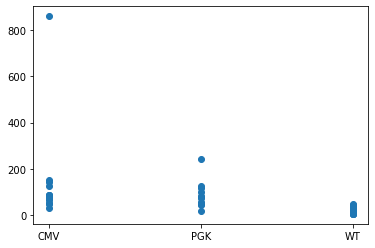

In [19]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.promoter, poscellmeans.mean_peak)

## Dealing with overplotting

This is not the worst but certainly not the clearest due to the outlier among the CMV data (good thing we didnt just plot bars!) and the fact that the points are largely overlapping. This broad issue of overlapping data is called overplotting. There are a few ways to deal with this. First, we can try adding some transparency which will clarify where many points are sitting on top of one another with the `alpha` argument. I'll also change the color to black since adding color here isn't likely to convey any additional information.

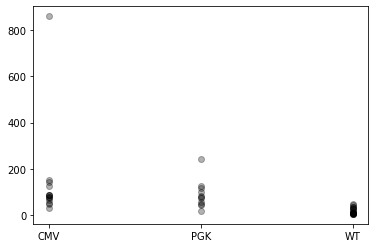

In [20]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.promoter, poscellmeans.mean_peak, alpha=0.3, color="black");

This is a bit better. We can see that there are some dark regions where data is overlapping but it's hard to tell just how much. Two potential ways to deal with this are making our points smaller so they don't overlap or adding some jitter to their x position so they aren't all in a line. First, let's try making our points smaller with the `s` argument.

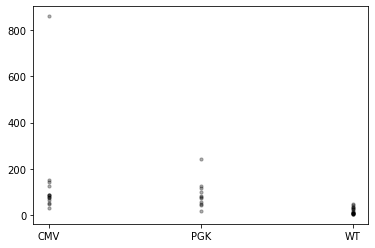

In [21]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.promoter, poscellmeans.mean_peak, alpha=0.3, color="black", s=10);

It looks like our datapoints would have to be quite small to prevent overlapping and that has its own issues with readability so let's instead turn to adding jitter to our data. Many plotting packages have an argument to add jitter but matplotlib is pretty bare bones so it does not. However with great simplicity comes great flexibility so we can come up with a hacky answer to this problem. 

First, I am going to use the knowledge that given categorical variables like our promoter names, by default, matplotlib will plot the bars at integer positions starting at 0. So, for 3 categories (CMV, PGK, WT) the bars will be centered at 0, 1, and 2.

Knowing this I will make a new column for the x-position of my scatterplot based on the what promoter that cell has and call it `x`. I use `poscellmean.assign` to first make this new column in the dataframe and initially assign it all zeros using `np.zeros`. Next, I use a for loop to loop through each row of the dataframe and use if statements to check the following:
- if the value of the column `promoter` in that row is `"CMV"` put a 0 into column `x`
- else if the value of the column `promoter` in that row is `"PGK"` put a 1 into column `x`
- else if the value of the column `promoter` in that row is anything else put a 2 into column `x`

Below the code I am showing the first 20 lines of the table and you can see that it appears to be assigned correctly.

In [22]:
poscellmeans = poscellmeans.assign(x = np.zeros(len(poscellmeans)))

for i in range(len(poscellmeans)):
    if poscellmeans.promoter[i] == "CMV":
        poscellmeans.loc[i,'x'] = 0
    elif poscellmeans.promoter[i] == "PGK":
        poscellmeans.loc[i,'x'] =1
    else:
        poscellmeans.loc[i,'x'] = 2
        
poscellmeans.head(20)

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x
0,CMV,20220125_N2A_mp1_CMV1_pos_analyzed.csv,860.877182,848.311891,1.54,4.20,0.0
1,CMV,20220125_N2A_mp1_CMV2_pos_analyzed.csv,45.195107,40.929065,1.55,4.42,0.0
2,CMV,20220126_N2A_mp1_CMV1_pos_analyzed.csv,31.811906,26.794968,2.45,4.34,0.0
3,CMV,20220126_N2A_mp1_CMV2_pos_analyzed.csv,151.528319,43.083088,1.68,2.79,0.0
4,CMV,20220126_N2A_mp1_CMV3_pos_analyzed.csv,78.074737,46.576213,2.09,4.08,0.0
5,CMV,20220127_N2A_mp1_CMV1_pos_analyzed.csv,85.070526,62.341495,1.37,4.24,0.0
6,CMV,20220127_N2A_mp1_CMV2_pos_analyzed.csv,79.420418,43.799764,1.86,4.28,0.0
7,CMV,20220127_N2A_mp1_CMV3_pos_analyzed.csv,72.380009,63.593598,1.75,4.21,0.0
8,CMV,20220127_N2A_mp1_CMV4_pos_analyzed.csv,84.716478,78.105303,2.07,3.14,0.0
9,CMV,20220201_N2A_mp1_CMV1_pos_analyzed.csv,143.878180,68.691708,1.25,5.23,0.0


We will use this new column `x` as our x axis position for the scatterplot.

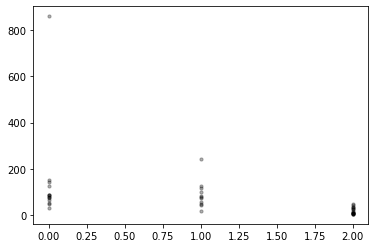

In [23]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.3, color="black", s=10);

So far nothing has changed. This is where we make the magic happen.

Now that we have a number for where to put these points on the x-axis let's add a little noise to it to act as our "jitter". For this we will use the package `random`. In coding there is no TRULY random process. Everything is pseudorandom. This is great from a reproducibility standpoint. We can set a **seed** or give a number as a starting point for our random number generator and the output will always be the same. If you change the seed it will be different but if you change back you will see that the previous output is perfectly reproduced. I will set a seed using the function `random.seed()` and then for each line of the if else statement rather than setting it to 0, 1, or 2. I will set the value to 0, 1, or 2 plus some random noise to add that jitter. Lets see what our new dataframe looks like:

In [24]:
poscellmeans = poscellmeans.assign(x = np.zeros(len(poscellmeans)))

random.seed(43)
for i in range(len(poscellmeans)):
    if poscellmeans.promoter[i] == "CMV":
        poscellmeans.loc[i,'x'] = 0 + (random.randrange(-150, 150)/1000)
    elif poscellmeans.promoter[i] == "PGK":
        poscellmeans.loc[i,'x'] =1 + (random.randrange(-150, 150)/1000)
    else:
        poscellmeans.loc[i,'x'] = 2 + (random.randrange(-150, 150)/1000)
        
poscellmeans.head(20)

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x
0,CMV,20220125_N2A_mp1_CMV1_pos_analyzed.csv,860.877182,848.311891,1.54,4.20,-0.131
1,CMV,20220125_N2A_mp1_CMV2_pos_analyzed.csv,45.195107,40.929065,1.55,4.42,-0.004
2,CMV,20220126_N2A_mp1_CMV1_pos_analyzed.csv,31.811906,26.794968,2.45,4.34,-0.077
3,CMV,20220126_N2A_mp1_CMV2_pos_analyzed.csv,151.528319,43.083088,1.68,2.79,0.086
4,CMV,20220126_N2A_mp1_CMV3_pos_analyzed.csv,78.074737,46.576213,2.09,4.08,0.039
5,CMV,20220127_N2A_mp1_CMV1_pos_analyzed.csv,85.070526,62.341495,1.37,4.24,-0.101
6,CMV,20220127_N2A_mp1_CMV2_pos_analyzed.csv,79.420418,43.799764,1.86,4.28,0.082
7,CMV,20220127_N2A_mp1_CMV3_pos_analyzed.csv,72.380009,63.593598,1.75,4.21,0.105
8,CMV,20220127_N2A_mp1_CMV4_pos_analyzed.csv,84.716478,78.105303,2.07,3.14,-0.141
9,CMV,20220201_N2A_mp1_CMV1_pos_analyzed.csv,143.878180,68.691708,1.25,5.23,0.113


Notice that I can scale the amount of jitter by adjusting the input to `random.randrange()`. `random.randrange()` will select a random integer between the two integers I pass as arguments. I want to make sure that the scale of the noise is much less then the separation between categories (CMV, PGK, and WT) which are separated by 1 so I divide the output by 1000. You can play with these numbers until you find something you like but the scatterplot will now look as follows:

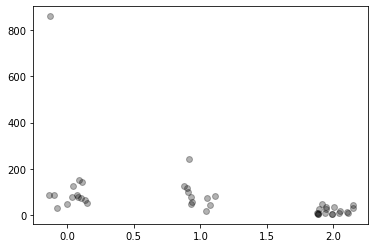

In [25]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.3, color="black", s=35);

You can change the seed until you get a pattern you like or change the scaling if you wish but I think in general this looks much better. There are fancier ways of adding jitter like beeswarm plots or quasirandom plots which you can look into if you wish. I will consolidate this new tool into a function called `x_jitter()` that we can reuse going forward

In [92]:
def x_jitter(df):
    df = df.assign(x = np.zeros(len(df)))
    random.seed(43)
    for i in range(len(df)):
        if df.promoter[i] == "CMV":
            df.loc[i,'x'] = 0 + (random.randrange(-150, 150)/1000)
        elif df.promoter[i] == "PGK":
            df.loc[i,'x'] =1 + (random.randrange(-150, 150)/1000)
        else:
            df.loc[i,'x'] = 2 + (random.randrange(-150, 150)/1000)
    return df

## Making a barplot

Now that we have our scatterplot we also want to have the barplot in the same graph. First we need to generate the data for the bars. This will require us to groupby promoter and find the mean_peak and mean_ss (for later plotting) and putting them into a new dataframe. At this point the steps are likely looking familiar. The only difference is now we are using `.agg` instead of `.mean`. `.agg` allows us to pass a list of functions we want it to apply to the rows we pass through. Those functions will be the mean, standard deviation, and len (which will give us the number of observations). Notice that the table has two column headers or rather the headers are nested. For instance, under `mean_peak` theres a header for `mean`, `std` and `len` respectively. We will keep it this way for now.

In [27]:
promotermeans = poscellmeans.groupby("promoter")[['mean_peak', 'mean_ss']].agg([np.mean, np.std, len]).reset_index()
promotermeans

promoter   mean_peak                     mean_ss                
                  mean         std len        mean         std len
0      CMV  140.316378  210.260504  14  106.609991  214.280676  14
1      PGK   89.216586   60.488963  11   64.137075   53.565805  11
2       WT   18.564446   14.185784  18   16.386190   13.176956  18

We can now use this data and plot it as bars onto the axis with the scatterplot.

<BarContainer object of 3 artists>

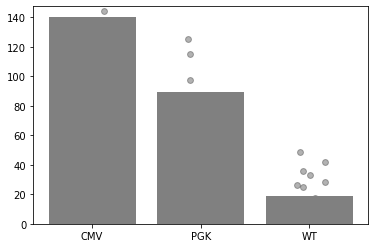

In [28]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.3, color="black", s=35);
ax.bar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], color="gray")

That doesn't look great. The axis limits seem to follow the limits of the bar graph instead of the scatterplot. The bars are also on top of the scatter points. Fortunately, this is an easy fix. Just switch the order that you add them to the axis!

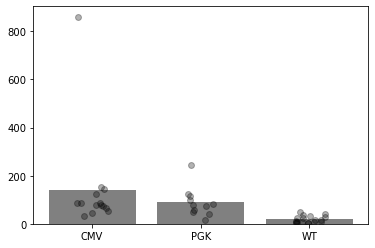

In [29]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], color="gray")
ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.3, color="black", s=35);


Much better! and notice that the x-axis has switched to the appropriate labels from the barplot data automatically! The black on gray is not particularly visible so we may want to change the color of the points or the bars to improve visibility. Here I will set the `edgecolor` and the `facecolor` (fill) individually so the bars and points pop. Feel free to play with the styling as you see fit.

Notice that since the column names are nested I had to call the `mean` from `mean_peak` in `promotermeans` by typing `promotermeans.mean_peak.loc[:, "mean"]`.

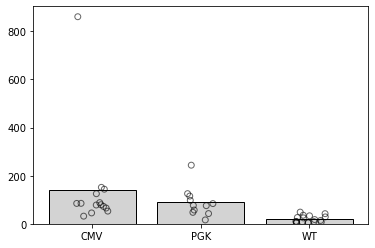

In [30]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");

## Adding error bars

We are almost there! Let's add some error bars to the data. Any sample measurement comes with some variance that should be conveyed. Here we are making inferences on the mean behavior so we will use the standard error of the mean. If instead you want to simply convey the variability of the sample data standard deviation would be more appropriate. 

Let's first make a new column in promotermeans that has our sem in it. Recall that the equation for sem is the standard deviation divided by the square root of the number of observations. It should be clear now why we used the `len` function as well. While I'm at it I will also do the same for the steady state since I can make multiple assignments with pandas `assign()` function.

In [34]:
promotermeans = promotermeans.assign(mean_peak_sem = promotermeans.mean_peak.loc[:,"std"] / np.sqrt(promotermeans.mean_peak.loc[:,"len"]),
                                    mean_ss_sem = promotermeans.mean_ss.loc[:,"std"] / np.sqrt(promotermeans.mean_ss.loc[:,"len"]))
promotermeans

promoter   mean_peak                     mean_ss                  \
                  mean         std len        mean         std len   
0      CMV  140.316378  210.260504  14  106.609991  214.280676  14   
1      PGK   89.216586   60.488963  11   64.137075   53.565805  11   
2       WT   18.564446   14.185784  18   16.386190   13.176956  18   

  mean_peak_sem mean_ss_sem  
                             
0     56.194483   57.268920  
1     18.238109   16.150698  
2      3.343621    3.105838

Notice again the nested indexing to pull out the `std` and `len` from `mean_peak` and `mean_ss` respectively. However, the new values I assigned are NOT nested (see how they are off on their own). I did this for convenience.

Now I can use the plotting function `ax.errorbar()` to plot our error bars. It takes `x` and `y` arguments for the midpoint of the errorbars and them an optional `yerr` and `xerr` argument (we will only have y error here). We will assign the column `promotermeans.mean_peak_sem` to `yerr`. I also set `ls='none'` for linestyle=none which prevents matplotlib from automatically connecting the errorbars with a line. The `color` is set to black and the `capsize` is set to 7. The optional argument `capsize` adds the horizontal line to the top and bottom of the error bars

<ErrorbarContainer object of 3 artists>

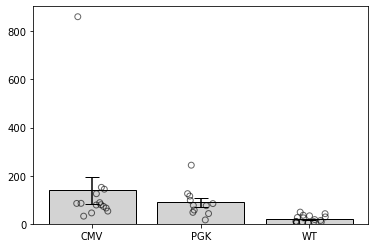

In [35]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], yerr = promotermeans.mean_peak_sem, ls='none', color="black", capsize=7)

## Finishing touches

Now we can do our typical styling with axis labels and perhaps make a version of our graph with and without the outlier for clarity and we are done!

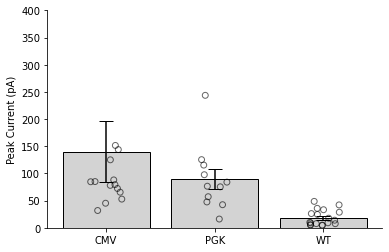

In [37]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(poscellmeans.x, poscellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeans.promoter, promotermeans.mean_peak.loc[:, "mean"], yerr = promotermeans.mean_peak_sem, ls='none', color="black", capsize=7)

ax.set_ylim(0,400)
ax.set_ylabel("Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("peakcurrents_bypromoterzoom.png")

I will now quickly make the same plot for steady state. You should make each plot for negative voltages as well. I suggest for the outlier you show the raw trace in lab meeting as well.

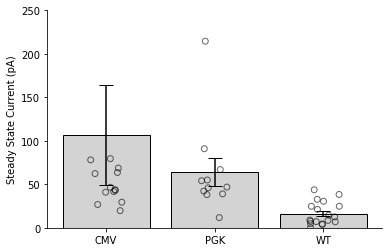

In [38]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeans.promoter, promotermeans.mean_ss.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(poscellmeans.x, poscellmeans.mean_ss, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeans.promoter, promotermeans.mean_ss.loc[:, "mean"], yerr = promotermeans.mean_ss_sem, ls='none', color="black", capsize=7)

ax.set_ylim(0,250)
ax.set_ylabel("Steady State Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig("sscurrents_bypromoter.png")

## Plotting %Inactivation

We have an idea of our peak currents and mean steady-state currents but our original question was on what the effect of expression level was on inactivation. The constructs were simply a means to explore this question. One way to quantify inactivation is the ratio of steady state to peak current. We already have our data organized in a way to make this sort of calculation convenient. We can also show this data in the same format as a bar plot with overlayed scatter plot.

First lets find the ratio and add it as a new column to our "by cell" summary dataframe.

In [39]:
poscellmeans = poscellmeans.assign(percent_inactivation = poscellmeans.mean_ss / poscellmeans.mean_peak)
poscellmeans.head(20)
poscellmeans = poscellmeans.query("mean_peak >= 10")

Next, lets add the promoter-wise mean of this value as a new column to our `promotermeans` dataframe. We can just find it the same way we did earlier with groupby and agg then just concatenate the two dataframes horizontally with `pd.concat()`.

In [40]:
promotermeans = pd.concat([promotermeans, poscellmeans.groupby("promoter")[['percent_inactivation']].agg([np.mean, np.std, len]).reset_index(drop=True)], axis=1)
promotermeans

promoter   mean_peak                     mean_ss                  \
                  mean         std len        mean         std len   
0      CMV  140.316378  210.260504  14  106.609991  214.280676  14   
1      PGK   89.216586   60.488963  11   64.137075   53.565805  11   
2       WT   18.564446   14.185784  18   16.386190   13.176956  18   

  mean_peak_sem mean_ss_sem percent_inactivation                
                                            mean       std len  
0     56.194483   57.268920             0.653120  0.229685  14  
1     18.238109   16.150698             0.729657  0.196307  11  
2      3.343621    3.105838             0.891708  0.035559  10

We need to also find the standard error of the mean for the percent inactivation data as we did earlier.

In [41]:
promotermeans = promotermeans.assign(percent_inactivation_sem = promotermeans.percent_inactivation.loc[:,"std"] / np.sqrt(promotermeans.percent_inactivation.loc[:,"len"]))

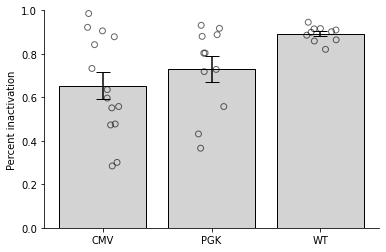

In [42]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeans.promoter, promotermeans.percent_inactivation.loc[:,"mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(poscellmeans.x, poscellmeans.percent_inactivation, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeans.promoter, promotermeans.percent_inactivation.loc[:,"mean"], yerr = promotermeans.percent_inactivation_sem, ls='none', color="black", capsize=7)

ax.set_ylim(0,1)
ax.set_ylabel("Percent inactivation")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig("percent_inactivation_pos")

In [43]:
poscellmeans

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x,percent_inactivation
0,CMV,20220125_N2A_mp1_CMV1_pos_analyzed.csv,860.877182,848.311891,1.54,4.20,-0.131,0.985404
1,CMV,20220125_N2A_mp1_CMV2_pos_analyzed.csv,45.195107,40.929065,1.55,4.42,-0.004,0.905608
2,CMV,20220126_N2A_mp1_CMV1_pos_analyzed.csv,31.811906,26.794968,2.45,4.34,-0.077,0.842294
3,CMV,20220126_N2A_mp1_CMV2_pos_analyzed.csv,151.528319,43.083088,1.68,2.79,0.086,0.284324
4,CMV,20220126_N2A_mp1_CMV3_pos_analyzed.csv,78.074737,46.576213,2.09,4.08,0.039,0.596559
5,CMV,20220127_N2A_mp1_CMV1_pos_analyzed.csv,85.070526,62.341495,1.37,4.24,-0.101,0.732821
6,CMV,20220127_N2A_mp1_CMV2_pos_analyzed.csv,79.420418,43.799764,1.86,4.28,0.082,0.551492
7,CMV,20220127_N2A_mp1_CMV3_pos_analyzed.csv,72.380009,63.593598,1.75,4.21,0.105,0.878607
8,CMV,20220127_N2A_mp1_CMV4_pos_analyzed.csv,84.716478,78.105303,2.07,3.14,-0.141,0.921961
9,CMV,20220201_N2A_mp1_CMV1_pos_analyzed.csv,143.878180,68.691708,1.25,5.23,0.113,0.477430


Create the same plots for negative voltages. What would you conclude based on the data? Are there any caveats to this? Could you improve your dataset, experimental design, or analysis in any way?

## Scatterplot of percent inactivation as a function of peak current

Remember that ultimately the promoters were simply a tool to explore more of the parameter space of channel expression levels. We aren't interested in the percent inactivation for each construct per se. We are actually interested in whether or not inactivation scales with expression level. We do not have access to the expression level in this experiment but a reasonable (with some concessions and caveats) substitute may be the peak current. Let's see if we see a relationship between the %inactivation and peak current amplitude using a scatterplot.

We have gone over all the tools to make this plot previously. Each point on the plot should be an individual cell so we will use the `poscellmeans` data here.

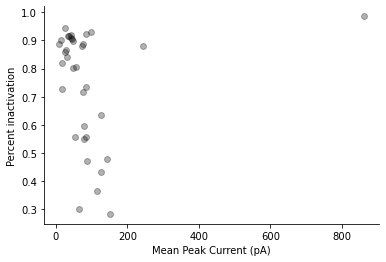

In [44]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.mean_peak, poscellmeans.percent_inactivation, alpha=0.3, color="black", s=35);

#ax.set_xlim(0, 400)
ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

With the exception of that same outlier we if we zoom in on the other datapoints there may be a weak correlation here. Since we are simply exploring the data here we will ignore the outlier for now but we should be VERY careful about doing this in general. We see that the peak current is well past the others so we can subset the data to remove it using pandas query() and setting a threshold at a reasonable mean_peak value.

In [45]:
poscellmeanssub = poscellmeans.query("mean_peak < 600")

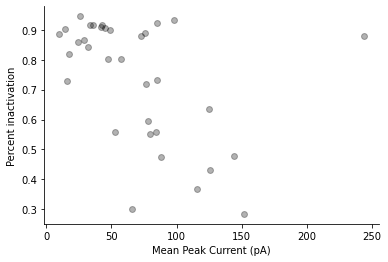

In [46]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeanssub.mean_peak, poscellmeanssub.percent_inactivation, alpha=0.3, color="black", s=35);

ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Linear Correlation

We may want to quantify this relationship. A first pass may be to perform a linear fit and quantify the correlation between the parameters. To make it simple to digest I will first make a new dataframe with just the two columns of interest: `percent_inactivation` and `mean_peak`. I pulled out the columns and saved them to `inact_v_meanpeak` by indexing using a list of column names in square brackets. Then, pandas has a built-in `.corr()` function to find the correlation coefficient. From this we see that the correlation coefficient is ~-0.58.

As a general rule of thumb you can think of correlations as follows.
- 1–0.8 → Very strong
- 0.799–0.6 → Strong
- 0.599–0.4 → Moderate
- 0.399–0.2 → Weak
- 0.199–0 → Very Weak

Although, if you know something about the way the system behaves you may want to think about this differently.

In [47]:
inact_v_meanpeak =  poscellmeanssub[['mean_peak', 'percent_inactivation']]
inact_v_meanpeak.corr()

,mean_peak,percent_inactivation
mean_peak,1.000000,-0.445321
percent_inactivation,-0.445321,1.000000


We may want to visualize this relationship by fitting a line to the data. Numpy has a convenient function `np.polyfit` that will let us fit a polynomial of any degree to data. A linear fit is simply a first degree polynomial.

In [48]:
coefs = np.polyfit(inact_v_meanpeak.mean_peak, inact_v_meanpeak.percent_inactivation, 1)
coefs

array([-0.00185869,  0.86761429])

The two numbers are the coefficients of the fit. For a linear fit y=b + ax, the first coefficient is a and the second coefficient is b in the output of `np.polyfit()` with degree 1. With the equation in hand we can plot the fit. First, let us write a function for our line.

In [49]:
def linFit(coefs, x):
    return coefs[1] + coefs[0]*x

Now we can simply supply coefficients and some dummy values for x (spanning our plotting range) and get a line. We will use numpys `np.linspace` function to generate our dummy x values. From the previous scatterplot we can see that a line from 0 to about 250 will span most of the data. `np.linspace` takes 3 arguments: start, stop, and number of steps. 

In [50]:
xfine = np.linspace(0,250,100)
xfine

array([  0.        ,   2.52525253,   5.05050505,   7.57575758,
        10.1010101 ,  12.62626263,  15.15151515,  17.67676768,
        20.2020202 ,  22.72727273,  25.25252525,  27.77777778,
        30.3030303 ,  32.82828283,  35.35353535,  37.87878788,
        40.4040404 ,  42.92929293,  45.45454545,  47.97979798,
        50.50505051,  53.03030303,  55.55555556,  58.08080808,
        60.60606061,  63.13131313,  65.65656566,  68.18181818,
        70.70707071,  73.23232323,  75.75757576,  78.28282828,
        80.80808081,  83.33333333,  85.85858586,  88.38383838,
        90.90909091,  93.43434343,  95.95959596,  98.48484848,
       101.01010101, 103.53535354, 106.06060606, 108.58585859,
       111.11111111, 113.63636364, 116.16161616, 118.68686869,
       121.21212121, 123.73737374, 126.26262626, 128.78787879,
       131.31313131, 133.83838384, 136.36363636, 138.88888889,
       141.41414141, 143.93939394, 146.46464646, 148.98989899,
       151.51515152, 154.04040404, 156.56565657, 159.09

If we pass this into our function along with the coefficients we determined from fitting the data we get the following output:

In [51]:
yPredict = linFit(coefs, xfine)
yPredict

array([0.86761429, 0.86292064, 0.85822698, 0.85353333, 0.84883967,
       0.84414602, 0.83945237, 0.83475871, 0.83006506, 0.82537141,
       0.82067775, 0.8159841 , 0.81129045, 0.80659679, 0.80190314,
       0.79720948, 0.79251583, 0.78782218, 0.78312852, 0.77843487,
       0.77374122, 0.76904756, 0.76435391, 0.75966026, 0.7549666 ,
       0.75027295, 0.74557929, 0.74088564, 0.73619199, 0.73149833,
       0.72680468, 0.72211103, 0.71741737, 0.71272372, 0.70803006,
       0.70333641, 0.69864276, 0.6939491 , 0.68925545, 0.6845618 ,
       0.67986814, 0.67517449, 0.67048084, 0.66578718, 0.66109353,
       0.65639987, 0.65170622, 0.64701257, 0.64231891, 0.63762526,
       0.63293161, 0.62823795, 0.6235443 , 0.61885065, 0.61415699,
       0.60946334, 0.60476968, 0.60007603, 0.59538238, 0.59068872,
       0.58599507, 0.58130142, 0.57660776, 0.57191411, 0.56722046,
       0.5625268 , 0.55783315, 0.55313949, 0.54844584, 0.54375219,
       0.53905853, 0.53436488, 0.52967123, 0.52497757, 0.52028

Now let's plot this on top of our scatterplot and see what it looks like! For a line we can just use the plotting function `ax.plot()` from matplotlib.

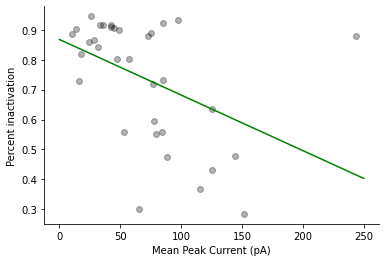

In [52]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeanssub.mean_peak, poscellmeanssub.percent_inactivation, alpha=0.3, color="black", s=35);
ax.plot(xfine, yPredict, color="green")

ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Adding annotations

We can also add text annotations to our plot. This may be useful to consolidate information. For instance let's add the correlation coefficient we found to the plot with the linear fit on it. The linear fit was in `inact_v_meanpeak.corr()`. I am also rounding the number to two decimal places for clarity using `np.round(value, 2)`. Then, I am making the annotation text by converting the numerical value (the rounded number) into a text string using the `str()` function. I can concatenate strings by just adding them so the text will altogether say "r = -0.58".

In [53]:
ann_txt = "r = " + str(np.round(inact_v_meanpeak.corr().mean_peak[1],2))
ann_txt

'r = -0.45'

Matplotlib has an annotation function `ax.annotate()`. The minimal arguments are the annotation text and the x and y positions passed as a list so we can add it to our plot as follows:

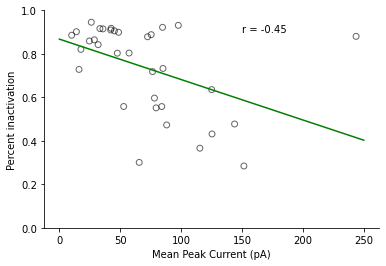

In [54]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeanssub.mean_peak, poscellmeanssub.percent_inactivation, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.plot(xfine, yPredict, color="green")
ax.annotate(ann_txt, [150, 0.9])

ax.set_ylim(0, 1)
ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig("inact_vs_peak_pos")


Can you do the same sort of analysis for mean_peak current and pipette resistance. Do you see a relationship? What might this suggest? (Remember pipette resistance will to some degree relate to the size of the opening in your pipette tip and thus patch size). Perform the same analysis for the negative voltage dataset.

# Positive and Negative SS Histograms

In [55]:
tablesummary = pd.read_csv("inactivation_summary.csv", header = 0)
usabletablesummary = tablesummary.query("usable == 1")

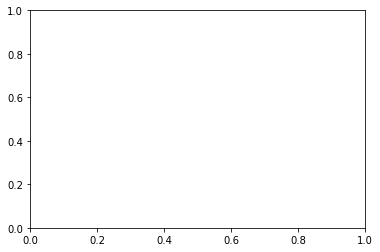

In [56]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

In [57]:
poscells = usabletablesummary.query("condition == 'pos'").reset_index(drop=True)
negcells = usabletablesummary.query("condition != 'pos'").reset_index(drop=True)

In [5]:
#posssratios = poscells.groupby(["filename"]).mean_ss.last() / poscells.groupby(["filename"]).mean_ss.first()
negssratios = negcells.groupby(["filename"]).mean_ss.last() / negcells.groupby(["filename"]).mean_ss.first()

NameError: name 'negcells' is not defined

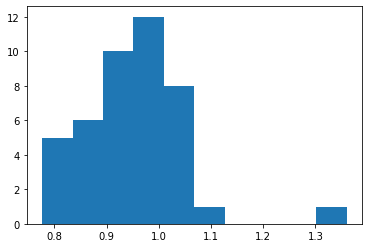

In [59]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posssratios);

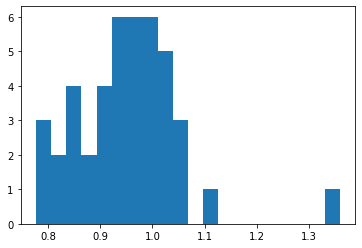

In [60]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posssratios, bins=20);

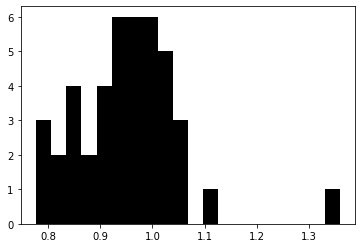

In [61]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posssratios, bins=20, color="black");

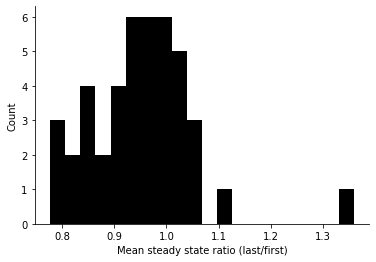

In [62]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(posssratios, bins=20, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Mean steady state ratio (last/first)');
#plt.savefig("PositiveSSRatioHistogram.png")

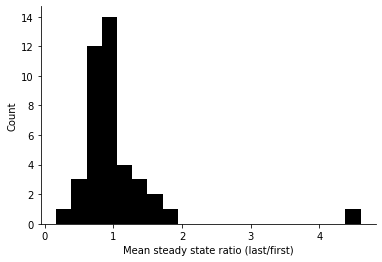

In [63]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')
ax.hist(negssratios, bins=20, color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')
ax.set_xlabel('Mean steady state ratio (last/first)');
#plt.savefig("NegativeSSRatioHistogram.png")

## Negative Mean Peak Current Bar Graph

In [64]:
negcells

,sweep,peak_time,mean_peak,sd_peak,mean_ss,sd_ss,promoter,filename,condition,pipette_resist,seal resist,notes on raw data,notes on analyzed graph,usable
0,0,5104.4,-11.549631,0.720512,-1.727460,0.636478,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1
1,1,5106.2,-8.685989,1.013561,-2.726574,0.589232,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1
2,2,5105.3,-11.945647,0.688406,-1.770787,0.769386,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1
3,3,5102.7,-11.309572,0.347920,-4.161856,0.867302,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1
4,4,5109.4,-9.497168,0.452893,-2.892662,0.702403,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,0,5398.0,-7.842199,0.557079,-3.331705,0.664290,WT,20220209_N2A_WT4_neg_analyzed.csv,neg,5.23,1.37,noisy baseline,peaks at end of stim,1
199,1,5397.7,-6.704419,0.680963,-1.409722,0.692681,WT,20220209_N2A_WT4_neg_analyzed.csv,neg,5.23,1.37,noisy baseline,peaks at end of stim,1
200,2,5397.7,-6.190827,0.537209,-1.116716,0.496601,WT,20220209_N2A_WT4_neg_analyzed.csv,neg,5.23,1.37,noisy baseline,peaks at end of stim,1
201,3,5397.6,-8.180519,1.024610,-3.104383,0.621222,WT,20220209_N2A_WT4_neg_analyzed.csv,neg,5.23,1.37,noisy baseline,peaks at end of stim,1


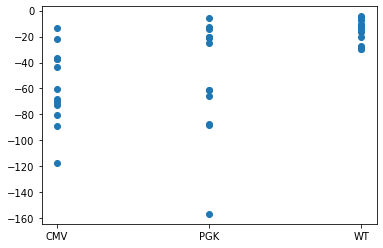

In [66]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

negcellmeans = negcells.groupby(["promoter", "filename"])[["promoter", "filename","mean_peak", "mean_ss", "seal resist", "pipette_resist"]].mean().reset_index()

ax.scatter(negcellmeans.promoter, negcellmeans.mean_peak)

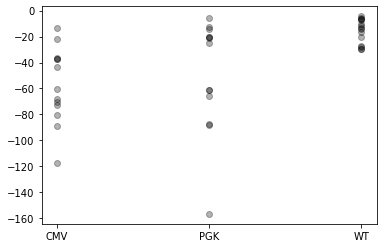

In [67]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.promoter, negcellmeans.mean_peak, alpha=0.3, color="black");

In [68]:
negcellmeans = negcellmeans.assign(x = np.zeros(len(negcellmeans)))

for i in range(len(negcellmeans)):
    if negcellmeans.promoter[i] == "CMV":
        negcellmeans.loc[i,'x'] = 0
    elif negcellmeans.promoter[i] == "PGK":
        negcellmeans.loc[i,'x'] =1
    else:
        negcellmeans.loc[i,'x'] = 2
        
negcellmeans.head(20)

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x
0,CMV,20220125_N2A_mp1_CMV2_neg_analyzed.csv,-13.660680,-10.599046,1.55,4.42,0.0
1,CMV,20220126_N2A_mp1_CMV1_neg_analyzed.csv,-21.615336,-17.142815,2.45,4.34,0.0
2,CMV,20220126_N2A_mp1_CMV2_neg_analyzed.csv,-117.381808,-25.112258,1.68,2.79,0.0
3,CMV,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-37.418301,-28.702957,2.09,4.08,0.0
4,CMV,20220127_N2A_mp1_CMV1_neg_analyzed.csv,-80.262874,-31.843971,1.37,4.24,0.0
5,CMV,20220127_N2A_mp1_CMV2_neg_analyzed.csv,-70.303860,-33.830956,1.86,4.28,0.0
6,CMV,20220127_N2A_mp1_CMV3_neg_analyzed.csv,-60.244527,-19.049019,1.75,4.21,0.0
7,CMV,20220127_N2A_mp1_CMV4_neg_analyzed.csv,-37.228177,-14.354239,2.07,3.14,0.0
8,CMV,20220201_N2A_mp1_CMV1_neg_analyzed.csv,-72.808421,-17.795760,1.25,5.23,0.0
9,CMV,20220202_N2A_mp1_CMV1_neg_analyzed.csv,-67.821798,-29.996963,1.18,4.55,0.0


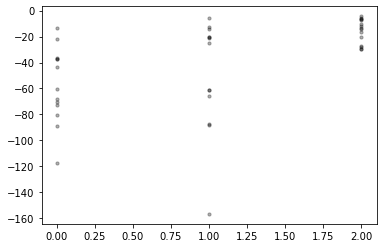

In [69]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.3, color="black", s=10);

In [70]:
negcellmeans = negcellmeans.assign(x = np.zeros(len(negcellmeans)))

random.seed(43)
for i in range(len(negcellmeans)):
    if negcellmeans.promoter[i] == "CMV":
        negcellmeans.loc[i,'x'] = 0 + (random.randrange(-150, 150)/1000)
    elif negcellmeans.promoter[i] == "PGK":
        negcellmeans.loc[i,'x'] =1 + (random.randrange(-150, 150)/1000)
    else:
        negcellmeans.loc[i,'x'] = 2 + (random.randrange(-150, 150)/1000)
        
negcellmeans.head(20)

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x
0,CMV,20220125_N2A_mp1_CMV2_neg_analyzed.csv,-13.660680,-10.599046,1.55,4.42,-0.131
1,CMV,20220126_N2A_mp1_CMV1_neg_analyzed.csv,-21.615336,-17.142815,2.45,4.34,-0.004
2,CMV,20220126_N2A_mp1_CMV2_neg_analyzed.csv,-117.381808,-25.112258,1.68,2.79,-0.077
3,CMV,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-37.418301,-28.702957,2.09,4.08,0.086
4,CMV,20220127_N2A_mp1_CMV1_neg_analyzed.csv,-80.262874,-31.843971,1.37,4.24,0.039
5,CMV,20220127_N2A_mp1_CMV2_neg_analyzed.csv,-70.303860,-33.830956,1.86,4.28,-0.101
6,CMV,20220127_N2A_mp1_CMV3_neg_analyzed.csv,-60.244527,-19.049019,1.75,4.21,0.082
7,CMV,20220127_N2A_mp1_CMV4_neg_analyzed.csv,-37.228177,-14.354239,2.07,3.14,0.105
8,CMV,20220201_N2A_mp1_CMV1_neg_analyzed.csv,-72.808421,-17.795760,1.25,5.23,-0.141
9,CMV,20220202_N2A_mp1_CMV1_neg_analyzed.csv,-67.821798,-29.996963,1.18,4.55,0.113


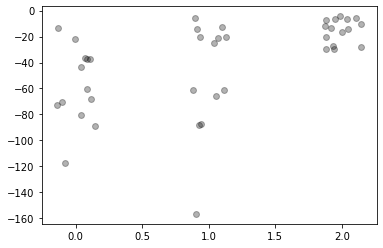

In [71]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.3, color="black", s=35);

In [72]:
promotermeansneg = negcellmeans.groupby("promoter")[['mean_peak', 'mean_ss']].agg([np.mean, np.std, len]).reset_index()
promotermeansneg

promoter  mean_peak                   mean_ss              
                 mean        std len       mean       std len
0      CMV -57.529132  29.287842  13 -21.978811  8.914463  13
1      PGK -49.182393  43.336759  13 -14.852506  9.766886  13
2       WT -15.366579   9.283584  15  -3.831009  2.475210  15

<BarContainer object of 3 artists>

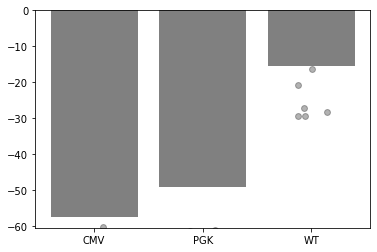

In [73]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.3, color="black", s=35);
ax.bar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], color="gray")

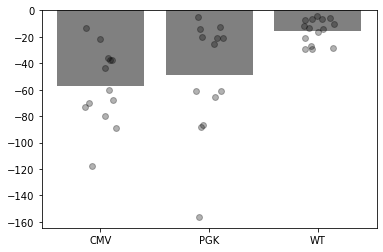

In [74]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], color="gray")
ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.3, color="black", s=35);

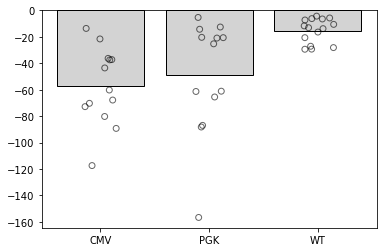

In [75]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");

In [76]:
promotermeansneg = promotermeansneg.assign(mean_peak_sem = promotermeansneg.mean_peak.loc[:,"std"] / np.sqrt(promotermeansneg.mean_peak.loc[:,"len"]),
                                    mean_ss_sem = promotermeansneg.mean_ss.loc[:,"std"] / np.sqrt(promotermeansneg.mean_ss.loc[:,"len"]))
promotermeansneg

promoter  mean_peak                   mean_ss               mean_peak_sem  \
                 mean        std len       mean       std len                 
0      CMV -57.529132  29.287842  13 -21.978811  8.914463  13      8.122986   
1      PGK -49.182393  43.336759  13 -14.852506  9.766886  13     12.019454   
2       WT -15.366579   9.283584  15  -3.831009  2.475210  15      2.397011   

  mean_ss_sem  
               
0    2.472427  
1    2.708847  
2    0.639097

<ErrorbarContainer object of 3 artists>

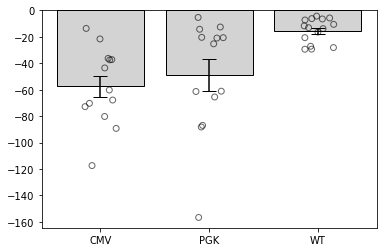

In [77]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], yerr = promotermeansneg.mean_peak_sem, ls='none', color="black", capsize=7)

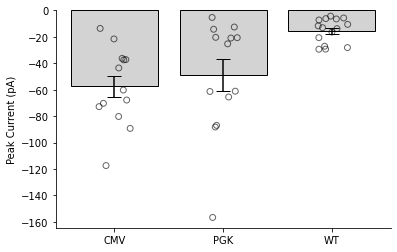

In [78]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(negcellmeans.x, negcellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansneg.promoter, promotermeansneg.mean_peak.loc[:, "mean"], yerr = promotermeansneg.mean_peak_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,400)
ax.set_ylabel("Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("negpeakcurrents_bypromoter.png")

# Negative SS Bar Graph

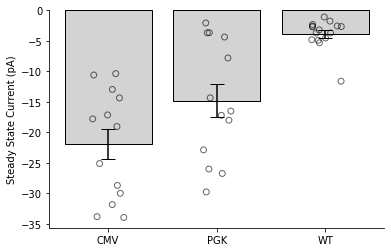

In [79]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansneg.promoter, promotermeansneg.mean_ss.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(negcellmeans.x, negcellmeans.mean_ss, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansneg.promoter, promotermeansneg.mean_ss.loc[:, "mean"], yerr = promotermeansneg.mean_ss_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,-250)
ax.set_ylabel("Steady State Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig("negsscurrents_bypromoter.png")

# Negative % Inactivation

In [80]:
negcellmeans = negcellmeans.assign(x = np.zeros(len(negcellmeans)))

random.seed(43)
for i in range(len(negcellmeans)):
    if negcellmeans.promoter[i] == "CMV":
        negcellmeans.loc[i,'x'] = 0 + (random.randrange(-150, 150)/1000)
    elif negcellmeans.promoter[i] == "PGK":
        negcellmeans.loc[i,'x'] =1 + (random.randrange(-150, 150)/1000)
    else:
        negcellmeans.loc[i,'x'] = 2 + (random.randrange(-150, 150)/1000)
        
negcellmeans.head(20)

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x
0,CMV,20220125_N2A_mp1_CMV2_neg_analyzed.csv,-13.660680,-10.599046,1.55,4.42,-0.131
1,CMV,20220126_N2A_mp1_CMV1_neg_analyzed.csv,-21.615336,-17.142815,2.45,4.34,-0.004
2,CMV,20220126_N2A_mp1_CMV2_neg_analyzed.csv,-117.381808,-25.112258,1.68,2.79,-0.077
3,CMV,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-37.418301,-28.702957,2.09,4.08,0.086
4,CMV,20220127_N2A_mp1_CMV1_neg_analyzed.csv,-80.262874,-31.843971,1.37,4.24,0.039
5,CMV,20220127_N2A_mp1_CMV2_neg_analyzed.csv,-70.303860,-33.830956,1.86,4.28,-0.101
6,CMV,20220127_N2A_mp1_CMV3_neg_analyzed.csv,-60.244527,-19.049019,1.75,4.21,0.082
7,CMV,20220127_N2A_mp1_CMV4_neg_analyzed.csv,-37.228177,-14.354239,2.07,3.14,0.105
8,CMV,20220201_N2A_mp1_CMV1_neg_analyzed.csv,-72.808421,-17.795760,1.25,5.23,-0.141
9,CMV,20220202_N2A_mp1_CMV1_neg_analyzed.csv,-67.821798,-29.996963,1.18,4.55,0.113


In [81]:
if "percent_inactivation" not in negcellmeans.columns:
    negcellmeans = negcellmeans.assign(percent_inactivation = negcellmeans.mean_ss / negcellmeans.mean_peak)
    
negcellmeans.head(20)
negcellmeans = negcellmeans.query("mean_peak <= -10")
negcellmeans

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x,percent_inactivation
0,CMV,20220125_N2A_mp1_CMV2_neg_analyzed.csv,-13.660680,-10.599046,1.55,4.42,-0.131,0.775880
1,CMV,20220126_N2A_mp1_CMV1_neg_analyzed.csv,-21.615336,-17.142815,2.45,4.34,-0.004,0.793086
2,CMV,20220126_N2A_mp1_CMV2_neg_analyzed.csv,-117.381808,-25.112258,1.68,2.79,-0.077,0.213937
3,CMV,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-37.418301,-28.702957,2.09,4.08,0.086,0.767083
4,CMV,20220127_N2A_mp1_CMV1_neg_analyzed.csv,-80.262874,-31.843971,1.37,4.24,0.039,0.396746
5,CMV,20220127_N2A_mp1_CMV2_neg_analyzed.csv,-70.303860,-33.830956,1.86,4.28,-0.101,0.481211
6,CMV,20220127_N2A_mp1_CMV3_neg_analyzed.csv,-60.244527,-19.049019,1.75,4.21,0.082,0.316195
7,CMV,20220127_N2A_mp1_CMV4_neg_analyzed.csv,-37.228177,-14.354239,2.07,3.14,0.105,0.385575
8,CMV,20220201_N2A_mp1_CMV1_neg_analyzed.csv,-72.808421,-17.795760,1.25,5.23,-0.141,0.244419
9,CMV,20220202_N2A_mp1_CMV1_neg_analyzed.csv,-67.821798,-29.996963,1.18,4.55,0.113,0.442291


In [82]:
promotermeansneg = pd.concat([promotermeansneg, negcellmeans.groupby("promoter")[['percent_inactivation']].agg([np.mean, np.std, len]).reset_index(drop=True)], axis=1)
promotermeansneg

promoter  mean_peak                   mean_ss               mean_peak_sem  \
                 mean        std len       mean       std len                 
0      CMV -57.529132  29.287842  13 -21.978811  8.914463  13      8.122986   
1      PGK -49.182393  43.336759  13 -14.852506  9.766886  13     12.019454   
2       WT -15.366579   9.283584  15  -3.831009  2.475210  15      2.397011   

  mean_ss_sem percent_inactivation                
                              mean       std len  
0    2.472427             0.444632  0.204739  13  
1    2.708847             0.372581  0.214342  12  
2    0.639097             0.240713  0.114664  10

In [83]:
promotermeansneg = promotermeansneg.assign(percent_inactivation_sem = promotermeansneg.percent_inactivation.loc[:,"std"] / np.sqrt(promotermeansneg.percent_inactivation.loc[:,"len"]))

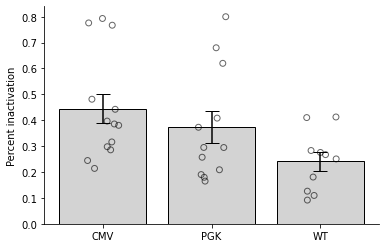

In [84]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansneg.promoter, promotermeansneg.percent_inactivation.loc[:,"mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(negcellmeans.x, negcellmeans.percent_inactivation, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansneg.promoter, promotermeansneg.percent_inactivation.loc[:,"mean"], yerr = promotermeansneg.percent_inactivation_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,1)
ax.set_ylabel("Percent inactivation")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("percent_inactivation_neg")

# % Inact vs Peak Current Neg

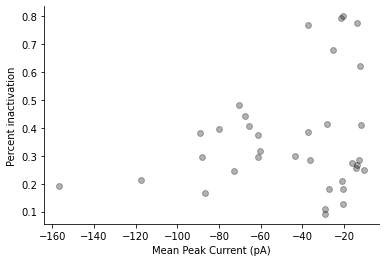

In [85]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.mean_peak, negcellmeans.percent_inactivation, alpha=0.3, color="black", s=35);

#ax.set_xlim(0, 400)
ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [86]:
inact_v_meanpeakneg =  negcellmeans[['mean_peak', 'percent_inactivation']]
inact_v_meanpeakneg.corr()

,mean_peak,percent_inactivation
mean_peak,1.00000,0.21782
percent_inactivation,0.21782,1.00000


In [87]:
coefsneg = np.polyfit(inact_v_meanpeakneg.mean_peak, inact_v_meanpeakneg.percent_inactivation, 1)
coefsneg

array([0.00126707, 0.4189462 ])

In [88]:
xfineneg = np.linspace(-160,0,100)
xfineneg

array([-160.        , -158.38383838, -156.76767677, -155.15151515,
       -153.53535354, -151.91919192, -150.3030303 , -148.68686869,
       -147.07070707, -145.45454545, -143.83838384, -142.22222222,
       -140.60606061, -138.98989899, -137.37373737, -135.75757576,
       -134.14141414, -132.52525253, -130.90909091, -129.29292929,
       -127.67676768, -126.06060606, -124.44444444, -122.82828283,
       -121.21212121, -119.5959596 , -117.97979798, -116.36363636,
       -114.74747475, -113.13131313, -111.51515152, -109.8989899 ,
       -108.28282828, -106.66666667, -105.05050505, -103.43434343,
       -101.81818182, -100.2020202 ,  -98.58585859,  -96.96969697,
        -95.35353535,  -93.73737374,  -92.12121212,  -90.50505051,
        -88.88888889,  -87.27272727,  -85.65656566,  -84.04040404,
        -82.42424242,  -80.80808081,  -79.19191919,  -77.57575758,
        -75.95959596,  -74.34343434,  -72.72727273,  -71.11111111,
        -69.49494949,  -67.87878788,  -66.26262626,  -64.64646

In [89]:
yPredictneg = linFit(coefsneg, xfineneg)
yPredictneg

array([0.21621433, 0.21826212, 0.22030992, 0.22235772, 0.22440551,
       0.22645331, 0.22850111, 0.23054891, 0.2325967 , 0.2346445 ,
       0.2366923 , 0.23874009, 0.24078789, 0.24283569, 0.24488348,
       0.24693128, 0.24897908, 0.25102687, 0.25307467, 0.25512247,
       0.25717026, 0.25921806, 0.26126586, 0.26331365, 0.26536145,
       0.26740925, 0.26945704, 0.27150484, 0.27355264, 0.27560043,
       0.27764823, 0.27969603, 0.28174382, 0.28379162, 0.28583942,
       0.28788721, 0.28993501, 0.29198281, 0.2940306 , 0.2960784 ,
       0.2981262 , 0.30017399, 0.30222179, 0.30426959, 0.30631738,
       0.30836518, 0.31041298, 0.31246077, 0.31450857, 0.31655637,
       0.31860416, 0.32065196, 0.32269976, 0.32474755, 0.32679535,
       0.32884315, 0.33089095, 0.33293874, 0.33498654, 0.33703434,
       0.33908213, 0.34112993, 0.34317773, 0.34522552, 0.34727332,
       0.34932112, 0.35136891, 0.35341671, 0.35546451, 0.3575123 ,
       0.3595601 , 0.3616079 , 0.36365569, 0.36570349, 0.36775

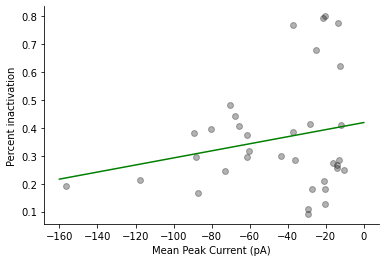

In [90]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.mean_peak, negcellmeans.percent_inactivation, alpha=0.3, color="black", s=35);
ax.plot(xfineneg, yPredictneg, color="green")

ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [91]:
ann_txtneg = "r = " + str(np.round(inact_v_meanpeakneg.corr().mean_peak[1],2))
ann_txtneg

'r = 0.22'

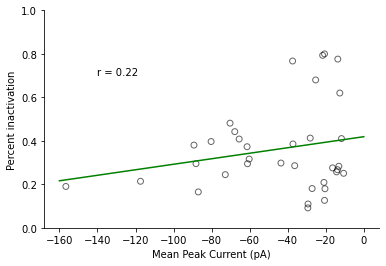

In [92]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(negcellmeans.mean_peak, negcellmeans.percent_inactivation, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.plot(xfineneg, yPredictneg, color="green")
ax.annotate(ann_txtneg, [-140, 0.7])

ax.set_ylim(0, 1)
ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("inact_vs_peak_neg")

# Pipette Resist vs Mean Peak 

In [134]:
poscellmeans

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x,percent_inactivation
0,CMV,20220125_N2A_mp1_CMV1_pos_analyzed.csv,860.877182,848.311891,1.54,4.20,-0.131,0.985404
1,CMV,20220125_N2A_mp1_CMV2_pos_analyzed.csv,45.195107,40.929065,1.55,4.42,-0.004,0.905608
2,CMV,20220126_N2A_mp1_CMV1_pos_analyzed.csv,31.811906,26.794968,2.45,4.34,-0.077,0.842294
3,CMV,20220126_N2A_mp1_CMV2_pos_analyzed.csv,151.528319,43.083088,1.68,2.79,0.086,0.284324
4,CMV,20220126_N2A_mp1_CMV3_pos_analyzed.csv,78.074737,46.576213,2.09,4.08,0.039,0.596559
5,CMV,20220127_N2A_mp1_CMV1_pos_analyzed.csv,85.070526,62.341495,1.37,4.24,-0.101,0.732821
6,CMV,20220127_N2A_mp1_CMV2_pos_analyzed.csv,79.420418,43.799764,1.86,4.28,0.082,0.551492
7,CMV,20220127_N2A_mp1_CMV3_pos_analyzed.csv,72.380009,63.593598,1.75,4.21,0.105,0.878607
8,CMV,20220127_N2A_mp1_CMV4_pos_analyzed.csv,84.716478,78.105303,2.07,3.14,-0.141,0.921961
9,CMV,20220201_N2A_mp1_CMV1_pos_analyzed.csv,143.878180,68.691708,1.25,5.23,0.113,0.477430


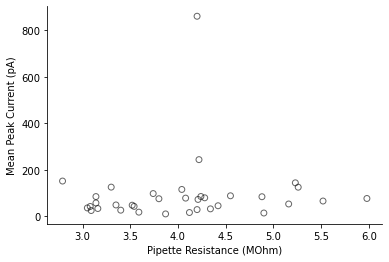

In [135]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(poscellmeans.pipette_resist, poscellmeans.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
#ax.plot(xfineneg, yPredictneg, color="green")
#ax.annotate(ann_txtneg, [-140, 0.7])

#ax.set_ylim(0, 1)
ax.set_ylabel("Mean Peak Current (pA)")
ax.set_xlabel("Pipette Resistance (MOhm)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig("inact_vs_peak_neg")

# First Peak Neg Peak Current Bar Graph

In [102]:
firstnegcellpeak = negcells.query("sweep == 0").reset_index(drop=True)
firstnegcellpeak

,sweep,peak_time,mean_peak,sd_peak,mean_ss,sd_ss,promoter,filename,condition,pipette_resist,seal resist,notes on raw data,notes on analyzed graph,usable
0,0,5104.4,-11.549631,0.720512,-1.727460,0.636478,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1
1,0,5109.5,-28.448706,0.767103,-2.811924,0.652427,WT,20220210_N2A_WT11_neg_analyzed.csv,neg,4.20,1.21,NaN,NaN,1
2,0,5117.8,-26.665267,1.817054,-6.648141,0.987157,WT,20220210_N2A_WT5_neg_analyzed.csv,neg,3.16,1.46,very noisy baseline,one trace seems noisy,1
3,0,5111.6,-29.187197,3.679646,-4.629513,0.988687,WT,20220210_N2A_WT2_neg_analyzed.csv,neg,3.09,1.68,noisy baseline,NaN,1
4,0,5344.0,-5.572630,1.280709,-5.167910,0.777668,WT,20220210_N2A_WT1_neg_analyzed.csv,neg,5.95,1.88,noisy,peaks at end of stim,1
5,0,5117.5,-15.428951,1.068574,-4.527216,0.688273,WT,20220210_N2A_WT7_neg_analyzed.csv,neg,3.40,1.35,NaN,one peak at end of stim,1
6,0,5105.9,-103.458300,1.909370,-21.995084,0.852384,PGK,20220128_N2A_mp1_PGK3_neg_analyzed.csv,neg,4.04,1.30,NaN,NaN,1
7,0,5209.0,-29.212368,1.512443,-22.042686,1.375187,PGK,20220128_N2A_mp1_PGK2_neg_analyzed.csv,neg,3.52,1.47,NaN,peaks all over stim,1
8,0,5113.5,-18.300447,0.575928,-5.033484,0.774549,PGK,20220128_N2A_mp1_PGK1_neg_analyzed.csv,neg,4.12,1.56,NaN,NaN,1
9,0,5109.8,-102.620050,2.525444,-14.721359,1.008028,PGK,20220126_N2A_mp1_PGK2_neg_analyzed.csv,neg,3.30,1.84,NaN,NaN,1


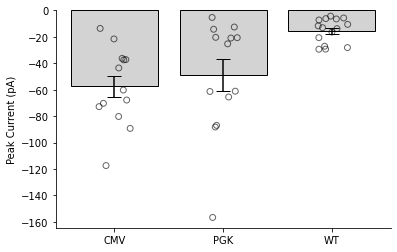

In [120]:

firstnegcellpeak = negcells.groupby(["promoter", "filename"])[["promoter", "filename","mean_peak", "mean_ss", "seal resist", "pipette_resist"]].mean().reset_index()
firstnegcellpeak = x_jitter(firstnegcellpeak)

promotermeansnegfirst = firstnegcellpeak.groupby("promoter")[['mean_peak', 'mean_ss']].agg([np.mean, np.std, len]).reset_index()
promotermeansnegfirst

promotermeansnegfirst = promotermeansnegfirst.assign(mean_peak_sem = promotermeansnegfirst.mean_peak.loc[:,"std"] / np.sqrt(promotermeansnegfirst.mean_peak.loc[:,"len"]),
                                    mean_ss_sem = promotermeansnegfirst.mean_ss.loc[:,"std"] / np.sqrt(promotermeansnegfirst.mean_ss.loc[:,"len"]))


f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansnegfirst.promoter, promotermeansnegfirst.mean_peak.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(firstnegcellpeak.x, firstnegcellpeak.mean_peak, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansnegfirst.promoter, promotermeansnegfirst.mean_peak.loc[:, "mean"], yerr = promotermeansnegfirst.mean_peak_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,400)
ax.set_ylabel("Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("firstnegpeakcurrents_bypromoter.png")

In [106]:
x_jitter(firstnegcellpeak)

,promoter,filename,mean_peak,mean_ss,seal resist,pipette_resist,x
0,CMV,20220125_N2A_mp1_CMV2_neg_analyzed.csv,-13.660680,-10.599046,1.55,4.42,-0.131
1,CMV,20220126_N2A_mp1_CMV1_neg_analyzed.csv,-21.615336,-17.142815,2.45,4.34,-0.004
2,CMV,20220126_N2A_mp1_CMV2_neg_analyzed.csv,-117.381808,-25.112258,1.68,2.79,-0.077
3,CMV,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-37.418301,-28.702957,2.09,4.08,0.086
4,CMV,20220127_N2A_mp1_CMV1_neg_analyzed.csv,-80.262874,-31.843971,1.37,4.24,0.039
5,CMV,20220127_N2A_mp1_CMV2_neg_analyzed.csv,-70.303860,-33.830956,1.86,4.28,-0.101
6,CMV,20220127_N2A_mp1_CMV3_neg_analyzed.csv,-60.244527,-19.049019,1.75,4.21,0.082
7,CMV,20220127_N2A_mp1_CMV4_neg_analyzed.csv,-37.228177,-14.354239,2.07,3.14,0.105
8,CMV,20220201_N2A_mp1_CMV1_neg_analyzed.csv,-72.808421,-17.795760,1.25,5.23,-0.141
9,CMV,20220202_N2A_mp1_CMV1_neg_analyzed.csv,-67.821798,-29.996963,1.18,4.55,0.113


# Neg First Sweep SS Bar Graph

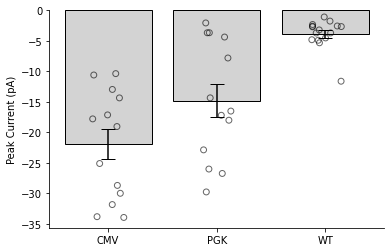

In [113]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansnegfirst.promoter, promotermeansnegfirst.mean_ss.loc[:, "mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(firstnegcellpeak.x, firstnegcellpeak.mean_ss, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansnegfirst.promoter, promotermeansnegfirst.mean_ss.loc[:, "mean"], yerr = promotermeansnegfirst.mean_ss_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,400)
ax.set_ylabel("Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("firstnegsscurrents_bypromoter.png")

# % Inact vs first peak current neg bar graph

In [121]:
if "percent_inactivation" not in firstnegcellpeak.columns:
    firstnegcellpeak = firstnegcellpeak.assign(percent_inactivation = firstnegcellpeak.mean_ss / firstnegcellpeak.mean_peak)
    
firstnegcellpeak.head(20)
firstnegcellpeak = firstnegcellpeak.query("mean_peak <= -10")

promotermeansnegfirst = pd.concat([promotermeansnegfirst, firstnegcellpeak.groupby("promoter")[['percent_inactivation']].agg([np.mean, np.std, len]).reset_index(drop=True)], axis=1)
promotermeansnegfirst

promotermeansnegfirst = promotermeansnegfirst.assign(percent_inactivation_sem = promotermeansnegfirst.percent_inactivation.loc[:,"std"] / np.sqrt(promotermeansnegfirst.percent_inactivation.loc[:,"len"]))

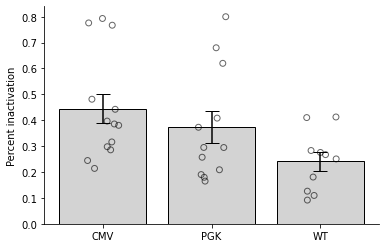

In [122]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.bar(promotermeansnegfirst.promoter, promotermeansnegfirst.percent_inactivation.loc[:,"mean"], facecolor="lightgray", edgecolor="black")
ax.scatter(firstnegcellpeak.x, firstnegcellpeak.percent_inactivation, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.errorbar(promotermeansnegfirst.promoter, promotermeansnegfirst.percent_inactivation.loc[:,"mean"], yerr = promotermeansnegfirst.percent_inactivation_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,1)
ax.set_ylabel("Percent inactivation")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("percent_inactivation_negfirst")

# % Inact vs Peak Current First Neg

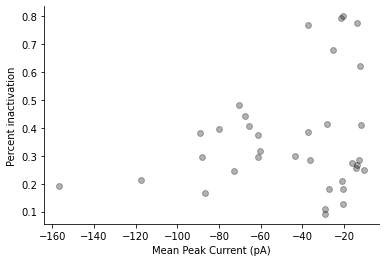

In [123]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(firstnegcellpeak.mean_peak, firstnegcellpeak.percent_inactivation, alpha=0.3, color="black", s=35);

#ax.set_xlim(0, 400)
ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [124]:
inact_v_meanpeaknegfirst =  firstnegcellpeak[['mean_peak', 'percent_inactivation']]
inact_v_meanpeaknegfirst.corr()

,mean_peak,percent_inactivation
mean_peak,1.00000,0.21782
percent_inactivation,0.21782,1.00000


In [125]:
coefsnegfirst = np.polyfit(inact_v_meanpeaknegfirst.mean_peak, inact_v_meanpeaknegfirst.percent_inactivation, 1)
coefsnegfirst

array([0.00126707, 0.4189462 ])

In [126]:
xfinenegfirst = np.linspace(-160,0,100)
xfinenegfirst

array([-160.        , -158.38383838, -156.76767677, -155.15151515,
       -153.53535354, -151.91919192, -150.3030303 , -148.68686869,
       -147.07070707, -145.45454545, -143.83838384, -142.22222222,
       -140.60606061, -138.98989899, -137.37373737, -135.75757576,
       -134.14141414, -132.52525253, -130.90909091, -129.29292929,
       -127.67676768, -126.06060606, -124.44444444, -122.82828283,
       -121.21212121, -119.5959596 , -117.97979798, -116.36363636,
       -114.74747475, -113.13131313, -111.51515152, -109.8989899 ,
       -108.28282828, -106.66666667, -105.05050505, -103.43434343,
       -101.81818182, -100.2020202 ,  -98.58585859,  -96.96969697,
        -95.35353535,  -93.73737374,  -92.12121212,  -90.50505051,
        -88.88888889,  -87.27272727,  -85.65656566,  -84.04040404,
        -82.42424242,  -80.80808081,  -79.19191919,  -77.57575758,
        -75.95959596,  -74.34343434,  -72.72727273,  -71.11111111,
        -69.49494949,  -67.87878788,  -66.26262626,  -64.64646

In [127]:
yPredictnegfirst = linFit(coefsneg, xfineneg)
yPredictnegfirst

array([0.21621433, 0.21826212, 0.22030992, 0.22235772, 0.22440551,
       0.22645331, 0.22850111, 0.23054891, 0.2325967 , 0.2346445 ,
       0.2366923 , 0.23874009, 0.24078789, 0.24283569, 0.24488348,
       0.24693128, 0.24897908, 0.25102687, 0.25307467, 0.25512247,
       0.25717026, 0.25921806, 0.26126586, 0.26331365, 0.26536145,
       0.26740925, 0.26945704, 0.27150484, 0.27355264, 0.27560043,
       0.27764823, 0.27969603, 0.28174382, 0.28379162, 0.28583942,
       0.28788721, 0.28993501, 0.29198281, 0.2940306 , 0.2960784 ,
       0.2981262 , 0.30017399, 0.30222179, 0.30426959, 0.30631738,
       0.30836518, 0.31041298, 0.31246077, 0.31450857, 0.31655637,
       0.31860416, 0.32065196, 0.32269976, 0.32474755, 0.32679535,
       0.32884315, 0.33089095, 0.33293874, 0.33498654, 0.33703434,
       0.33908213, 0.34112993, 0.34317773, 0.34522552, 0.34727332,
       0.34932112, 0.35136891, 0.35341671, 0.35546451, 0.3575123 ,
       0.3595601 , 0.3616079 , 0.36365569, 0.36570349, 0.36775

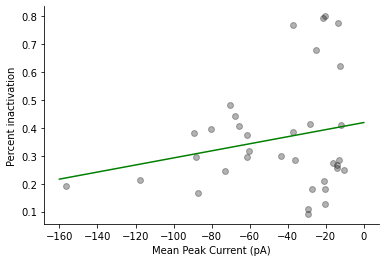

In [128]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(firstnegcellpeak.mean_peak, firstnegcellpeak.percent_inactivation, alpha=0.3, color="black", s=35);
ax.plot(xfinenegfirst, yPredictnegfirst, color="green")

ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [129]:
ann_txtnegfirst = "r = " + str(np.round(inact_v_meanpeaknegfirst.corr().mean_peak[1],2))
ann_txtnegfirst

'r = 0.22'

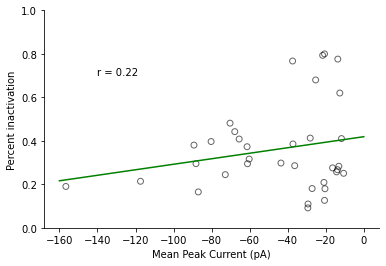

In [130]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(firstnegcellpeak.mean_peak, firstnegcellpeak.percent_inactivation, alpha=0.6, color="black", s=35, facecolor="none", edgecolor="black");
ax.plot(xfinenegfirst, yPredictnegfirst, color="green")
ax.annotate(ann_txtnegfirst, [-140, 0.7])

ax.set_ylim(0, 1)
ax.set_ylabel("Percent inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("inact_vs_peak_negfirst")

# Negative Data Time to 50% Inactivation

In [124]:
tablesummary = pd.read_csv("inactivation_summary.csv", header=0)

In [125]:
firstnegcells = tablesummary.query("sweep==0 & condition=='neg' & usable==1").reset_index(drop=True)
firstnegcells = firstnegcells.query("mean_peak <= -10")

In [126]:
firstnegcells = firstnegcells.assign(half_peak = (firstnegcells.mean_peak / 2))

In [127]:
firstnegcells = firstnegcells.query("half_peak <= mean_ss").reset_index(drop=True)

In [128]:

def getT50(dat, rowNum):
    filename = dat.loc[rowNum,:].filename[0:-13] + ".asc"
    relPath = "/Negative/" + filename.split("_")[0] + "/" + filename.split("_")[-2] + "/" + filename
    df = loadFile(os.getcwd() + relPath, headers = ["index", "ti", "i", "tp", "p", "tv", "v"])
    dfPreprocess = preprocess(df)
    
    print(relPath)
    roi = dat.loc[rowNum, "peak_time"],[5395]
    dfPreprocessSub = dfPreprocess.query("sweep==1 & ti >= @roi[0] & ti <= @roi[1]")
    threshold = dat.loc[rowNum, 'half_peak']
    below_half = dfPreprocessSub.query("i_blsub >= @threshold").reset_index(drop=True)
    indCrossing = ''.join([str(x) for x in np.diff(below_half.index)]).find("11111")
    return below_half.loc[indCrossing, "ti"]

getT50(firstnegcells, 1)

/Negative/20220210/WT11/20220210_N2A_WT11_neg.asc


5169.5

In [129]:
myT50s = np.zeros(len(firstnegcells))

for row in range(len(firstnegcells)):
        myT50s[row] = getT50(firstnegcells, row)
        
firstnegcells = firstnegcells.assign(T50s = myT50s)

/Negative/20220210/WT10/20220210_N2A_WT10_neg.asc
/Negative/20220210/WT11/20220210_N2A_WT11_neg.asc
/Negative/20220210/WT5/20220210_N2A_WT5_neg.asc
/Negative/20220210/WT2/20220210_N2A_WT2_neg.asc
/Negative/20220210/WT7/20220210_N2A_WT7_neg.asc
/Negative/20220128/PGK3/20220128_N2A_mp1_PGK3_neg.asc
/Negative/20220128/PGK1/20220128_N2A_mp1_PGK1_neg.asc
/Negative/20220126/PGK2/20220126_N2A_mp1_PGK2_neg.asc
/Negative/20220126/PGK1/20220126_N2A_mp1_PGK1_neg.asc
/Negative/20220126/CMV2/20220126_N2A_mp1_CMV2_neg.asc
/Negative/20220127/PGK2/20220127_N2A_mp1_PGK2_neg.asc
/Negative/20220127/CMV1/20220127_N2A_mp1_CMV1_neg.asc
/Negative/20220127/PGK1/20220127_N2A_mp1_PGK1_neg.asc
/Negative/20220127/CMV4/20220127_N2A_mp1_CMV4_neg.asc
/Negative/20220127/CMV3/20220127_N2A_mp1_CMV3_neg.asc
/Negative/20220127/CMV2/20220127_N2A_mp1_CMV2_neg.asc
/Negative/20220202/CMV1/20220202_N2A_mp1_CMV1_neg.asc
/Negative/20220202/CMV4/20220202_N2A_mp1_CMV4_neg.asc
/Negative/20220202/CMV3/20220202_N2A_mp1_CMV3_neg.asc


In [130]:
firstnegcells

,sweep,peak_time,mean_peak,sd_peak,mean_ss,sd_ss,promoter,filename,condition,pipette_resist,seal resist,notes on raw data,notes on analyzed graph,usable,half_peak,T50s
0,0,5104.4,-11.549631,0.720512,-1.727460,0.636478,WT,20220210_N2A_WT10_neg_analyzed.csv,neg,3.87,1.97,NaN,NaN,1,-5.774815,5116.4
1,0,5109.5,-28.448706,0.767103,-2.811924,0.652427,WT,20220210_N2A_WT11_neg_analyzed.csv,neg,4.20,1.21,NaN,NaN,1,-14.224353,5169.5
2,0,5117.8,-26.665267,1.817054,-6.648141,0.987157,WT,20220210_N2A_WT5_neg_analyzed.csv,neg,3.16,1.46,very noisy baseline,one trace seems noisy,1,-13.332634,5145.1
3,0,5111.6,-29.187197,3.679646,-4.629513,0.988687,WT,20220210_N2A_WT2_neg_analyzed.csv,neg,3.09,1.68,noisy baseline,NaN,1,-14.593599,5117.1
4,0,5117.5,-15.428951,1.068574,-4.527216,0.688273,WT,20220210_N2A_WT7_neg_analyzed.csv,neg,3.40,1.35,NaN,one peak at end of stim,1,-7.714475,5135.5
5,0,5105.9,-103.458300,1.909370,-21.995084,0.852384,PGK,20220128_N2A_mp1_PGK3_neg_analyzed.csv,neg,4.04,1.30,NaN,NaN,1,-51.729150,5112.8
6,0,5113.5,-18.300447,0.575928,-5.033484,0.774549,PGK,20220128_N2A_mp1_PGK1_neg_analyzed.csv,neg,4.12,1.56,NaN,NaN,1,-9.150223,5124.0
7,0,5109.8,-102.620050,2.525444,-14.721359,1.008028,PGK,20220126_N2A_mp1_PGK2_neg_analyzed.csv,neg,3.30,1.84,NaN,NaN,1,-51.310025,5115.1
8,0,5118.3,-62.580044,1.493293,-22.249964,1.303334,PGK,20220126_N2A_mp1_PGK1_neg_analyzed.csv,neg,3.14,1.32,little noise in baseline,NaN,1,-31.290022,5168.1
9,0,5113.0,-150.716660,3.442379,-22.780752,0.955683,CMV,20220126_N2A_mp1_CMV2_neg_analyzed.csv,neg,2.79,1.68,NaN,NaN,1,-75.358330,5120.1


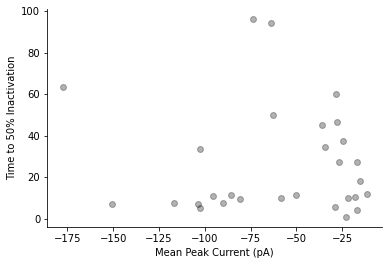

In [131]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(firstnegcells.mean_peak, firstnegcells.T50s - firstnegcells.peak_time, alpha=0.3, color="black", s=35);

#ax.set_xlim(0, 400)
ax.set_ylabel("Time to 50% Inactivation")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("T50_vs_peak")

In [94]:
dfPreprocess.to_csv('Preprocessed_Test.csv')

In [96]:
firstnegcells.to_csv('First_Neg_Cells.csv')

# Fitting Inactivation Taus

In [3]:
tablesummary = pd.read_csv("inactivation_summary.csv", header=0)

In [4]:
firstnegcells = tablesummary.query("sweep==0 & condition=='neg' & usable==1").reset_index(drop=True)
firstnegcells = firstnegcells.query("mean_peak <= -10").reset_index(drop=True)


In [33]:
def inactivationFits(cell):
    files = generatePaths(suffix = "neg_Preprocessed.csv")
    files = [i for i in files if "._" not in i]
    for f in files:
        if cell.filename[0:-13] in f:
            print(f)
            df = pd.read_csv(f, header=0)
            dfSub = df.query("sweep==1 & ti >= 5000 & ti <= 5500")
            filename = f
            
    peak10percent = cell.mean_peak * 0.1
    dfSubFiltered = dfSub.query("ti >= 5095 & ti <= 5395 & i_blsub <= @peak10percent")

    popt, pcov = curve_fit(doubleExp, dfSubFiltered.ti, dfSubFiltered.i_blsub, p0=[1, 200, 3, 200, 20], maxfev=50000)
    
    ax1, ax2 = plotSweeps(dfSub, "ti", "i_blsub", i_kwargs={"color":"black"})

    xfine = np.linspace(5095, 5400, 1000)
    yfine = doubleExp(xfine, *popt)
    ax2.plot(xfine, yfine, color = "orange", linewidth = 3)
    ax2.set_ylim(1.1 * np.min(dfSub.i_blsub), 10)
    ax2.annotate("tau = " + str(np.round(popt[4], 2)), [5030, -10], size = 16)
    plt.show()

    plt.savefig(filename[0:-17] + "_Inact_Tau.png")
        
    summarydf = pd.DataFrame({"filename":[cell.filename],"y0":[popt[0]], "a1":[popt[1]], "tau1":[popt[2]], "a2":[popt[3]], "tau2":[popt[4]]})
    return summarydf

In [81]:
temp = inactivationFits(firstnegcells.loc[35, :])

KeyError: 35

In [79]:
goodCells = pd.concat([goodCells, temp])

In [83]:
goodCells = goodCells.reset_index(drop=True)

In [84]:
goodCells

,filename,y0,a1,tau1,a2,tau2
0,20220210_N2A_WT10_neg_analyzed.csv,-2.444718,1.869458e+05,0.660015,8.218341e+00,52.977081
1,20220210_N2A_WT11_neg_analyzed.csv,0.950810,5.772638e+02,2.250731,3.210343e+01,116.365998
2,20220210_N2A_WT5_neg_analyzed.csv,-6.384959,2.297908e+02,4.129299,2.815556e+01,50.681620
3,20220210_N2A_WT2_neg_analyzed.csv,-4.117708,3.762085e+02,2.522640,3.104397e+01,27.738085
4,20220210_N2A_WT7_neg_analyzed.csv,-4.929469,4.698525e+03,11.531402,4.662162e+03,11.655816
5,20220128_N2A_mp1_PGK3_neg_analyzed.csv,-23.850780,1.745323e+05,4.250802,1.735027e+05,4.269084
6,20220128_N2A_mp1_PGK1_neg_analyzed.csv,-6.187912,5.377139e+03,9.360418,5.333777e+03,9.454195
7,20220126_N2A_mp1_PGK2_neg_analyzed.csv,-14.527016,1.388037e+06,3.270957,1.368983e+06,3.284942
8,20220126_N2A_mp1_PGK1_neg_analyzed.csv,-23.751184,1.018031e+04,2.347188,3.351077e+01,77.330750
9,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-33.723219,4.746592e+02,6.151413,3.389749e+01,41.005525


In [86]:
passes = firstnegcells.query("filename in @goodCells.filename").reset_index(drop=True)

In [88]:
goodCells = pd.merge(goodCells, passes, on= "filename")

In [89]:
goodCells

,filename,y0,a1,tau1,a2,tau2,sweep,peak_time,mean_peak,sd_peak,mean_ss,sd_ss,promoter,condition,pipette_resist,seal resist,notes on raw data,notes on analyzed graph,usable
0,20220210_N2A_WT10_neg_analyzed.csv,-2.444718,1.869458e+05,0.660015,8.218341e+00,52.977081,0,5104.4,-11.549631,0.720512,-1.727460,0.636478,WT,neg,3.87,1.97,NaN,NaN,1
1,20220210_N2A_WT11_neg_analyzed.csv,0.950810,5.772638e+02,2.250731,3.210343e+01,116.365998,0,5109.5,-28.448706,0.767103,-2.811924,0.652427,WT,neg,4.20,1.21,NaN,NaN,1
2,20220210_N2A_WT5_neg_analyzed.csv,-6.384959,2.297908e+02,4.129299,2.815556e+01,50.681620,0,5117.8,-26.665267,1.817054,-6.648141,0.987157,WT,neg,3.16,1.46,very noisy baseline,one trace seems noisy,1
3,20220210_N2A_WT2_neg_analyzed.csv,-4.117708,3.762085e+02,2.522640,3.104397e+01,27.738085,0,5111.6,-29.187197,3.679646,-4.629513,0.988687,WT,neg,3.09,1.68,noisy baseline,NaN,1
4,20220210_N2A_WT7_neg_analyzed.csv,-4.929469,4.698525e+03,11.531402,4.662162e+03,11.655816,0,5117.5,-15.428951,1.068574,-4.527216,0.688273,WT,neg,3.40,1.35,NaN,one peak at end of stim,1
5,20220128_N2A_mp1_PGK3_neg_analyzed.csv,-23.850780,1.745323e+05,4.250802,1.735027e+05,4.269084,0,5105.9,-103.458300,1.909370,-21.995084,0.852384,PGK,neg,4.04,1.30,NaN,NaN,1
6,20220128_N2A_mp1_PGK1_neg_analyzed.csv,-6.187912,5.377139e+03,9.360418,5.333777e+03,9.454195,0,5113.5,-18.300447,0.575928,-5.033484,0.774549,PGK,neg,4.12,1.56,NaN,NaN,1
7,20220126_N2A_mp1_PGK2_neg_analyzed.csv,-14.527016,1.388037e+06,3.270957,1.368983e+06,3.284942,0,5109.8,-102.620050,2.525444,-14.721359,1.008028,PGK,neg,3.30,1.84,NaN,NaN,1
8,20220126_N2A_mp1_PGK1_neg_analyzed.csv,-23.751184,1.018031e+04,2.347188,3.351077e+01,77.330750,0,5118.3,-62.580044,1.493293,-22.249964,1.303334,PGK,neg,3.14,1.32,little noise in baseline,NaN,1
9,20220126_N2A_mp1_CMV3_neg_analyzed.csv,-33.723219,4.746592e+02,6.151413,3.389749e+01,41.005525,0,5125.5,-53.600377,1.151435,-32.420966,1.314705,CMV,neg,4.08,2.09,NaN,peaks all over stim,1


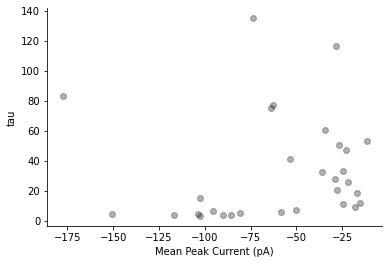

In [120]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

ax.scatter(goodCells.mean_peak, goodCells.tau2, alpha=0.3, color="black", s=35);

#ax.set_xlim(0, 400)
ax.set_ylabel("tau")
ax.set_xlabel("Mean Peak Current (pA)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("tau_vs_peak")

In [108]:
promotermeans = goodCells.groupby("promoter")['tau2'].agg([np.mean, np.std, len]).reset_index()
promotermeans = promotermeans.assign(tau2_sem = promotermeans.loc[:, "std"] / np.sqrt(promotermeans.loc[:,"len"]))

promotermeans

,promoter,mean,std,len,tau2_sem
0,CMV,18.173320,22.849818,11,6.889479
1,PGK,38.803720,44.856353,10,14.184824
2,WT,45.175474,31.930276,9,10.643425


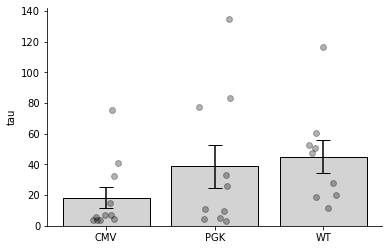

In [119]:
f, ax = plt.subplots()
f.patch.set_facecolor('white')

goodCells = x_jitter(goodCells)
ax.bar(promotermeans.promoter, promotermeans.loc[:,'mean'], facecolor="lightgray", edgecolor="black")
ax.scatter(goodCells.x, goodCells.tau2, alpha=0.3, color="black", s=35);
ax.errorbar(promotermeans.promoter, promotermeans.loc[:,"mean"], yerr = promotermeans.tau2_sem, ls='none', color="black", capsize=7)

#ax.set_ylim(0,1)
ax.set_ylabel("tau")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("tau_vs_promoter")